<a href="https://colab.research.google.com/github/mitsouma/IOT_Anomalies_Detection_System_Based_on_Tensor_Decomposition/blob/main/Last_version_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import warnings
import numpy as np
import pandas as pd
from tensorly.decomposition import parafac,non_negative_parafac
import tensorly as tl
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorly import unfold, fold
from tensorly.tenalg import khatri_rao
from numpy.linalg import lstsq
from tensorly.cp_tensor import cp_to_tensor
from sklearn.metrics import accuracy_score, log_loss
import time
from datetime import datetime
from sklearn.model_selection import train_test_split,KFold,cross_val_score
import torch
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import (confusion_matrix, classification_report,
                           roc_curve, precision_recall_curve, auc,
                           accuracy_score, precision_score, recall_score, f1_score)
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import random


In [1]:
pip install tensorly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 49.8 MB/s eta 0:00:00


"""
This pipeline is designed to detect anomalies in network traffic using a tensor-based deep learning approach.

Steps and Objectives:
---------------------
1. **Preprocessing & Tensor Construction**:
   - Multivariate network traffic data is aggregated over time windows.
   - A 4D tensor is built with dimensions: [Time_Window, Src IP, Dst IP,featues].

2. **Tensor Decomposition (CP)**:
   - The tensor is decomposed using CP (CANDECOMP/PARAFAC) to extract the underlying structure (normal behavior).
   - This reveals low-rank patterns, which capture typical traffic patterns.

3. **Reconstruction & Residual Calculation**:
   - We take the training tenssor and we compute its CP decomposition
   - Residuals are computed as the difference between the measure of the train tensor and the projection of this measure in the latent space.
4. **Anomaly Scoring**:
Since our goal aim to detect DDoS and DOS attack so:
   - Scores are aggregated per destination IP (`Dst IP`) and feature.
   - These scores reflect the degree of deviation from normal patterns.

5. **Deep Learning Classification**:
   - The aggregated anomaly scores are used as input to a neural network.
   - If labeled data is available, the model is trained in a supervised way to classify normal vs anomalous flows.
   - If labels are absent, an autoencoder is trained to learn normal behavior and detect deviations.

6. **Prediction**:
   - New traffic data is processed through the same pipeline.
   - The trained model predicts anomaly scores or binary classifications.

Main Goal:
----------
To detect abnormal network behavior in the IOT_data  by modeling traffic patterns as tensors, identifying deviations, and classifying them using deep learning models.
"""


In [3]:
warnings.filterwarnings("ignore")

In [4]:
tl.set_backend('pytorch')

In [5]:
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Define the dataset**

In [60]:
df1=pd.read_csv('/content/drive/MyDrive/BenignTraffic.pcap_Flow.csv')
df2=pd.read_csv('/content/drive/MyDrive/BenignTraffic1.pcap_Flow.csv')
df3=pd.read_csv('/content/drive/MyDrive/BenignTraffic2.pcap_Flow.csv')
df4=pd.read_csv('/content/drive/MyDrive/BenignTraffic3.pcap_Flow.csv')
df5=pd.read_csv('/content/drive/MyDrive/DDoS-HTTP_Flood-.pcap_Flow.csv')
df6=pd.read_csv('/content/drive/MyDrive/DoS-HTTP_Flood.pcap_Flow.csv')
df7=pd.read_csv('/content/drive/MyDrive/DoS-HTTP_Flood1.pcap_Flow.csv')

In [61]:
df1['label']=0
df2['label']=0
df3['label']=0
df4['label']=0
df5['label']=1
df5['label']=1
df6['label']=1
df7['label']=1

In [62]:
df1.replace([np.inf, -np.inf], np.nan, inplace=True)
df2.replace([np.inf, -np.inf], np.nan, inplace=True)
df3.replace([np.inf, -np.inf], np.nan, inplace=True)
df4.replace([np.inf, -np.inf], np.nan, inplace=True)
df5.replace([np.inf, -np.inf], np.nan, inplace=True)
df6.replace([np.inf, -np.inf], np.nan, inplace=True)
df7.replace([np.inf, -np.inf], np.nan, inplace=True)

In [64]:
#Drop na
for df in [df1,df2,df3,df4,df5,df6,df7]:
    r=df.isna().sum()
    print("nan for :are :",r[r>0])

nan for :are : Flow Bytes/s      35
Flow Packets/s    35
dtype: int64
nan for :are : Flow Bytes/s      35
Flow Packets/s    35
dtype: int64
nan for :are : Flow Bytes/s      45
Flow Packets/s    45
dtype: int64
nan for :are : Flow Bytes/s      17
Flow Packets/s    17
dtype: int64
nan for :are : Flow Bytes/s      1123
Flow Packets/s    1123
dtype: int64
nan for :are : Flow Bytes/s      40786
Flow Packets/s    40786
dtype: int64
nan for :are : Flow Bytes/s      38735
Flow Packets/s    38735
dtype: int64


In [65]:
#Shape of each dataset
print(df1.shape)
print(df2.shape)
print(df3.shape)
print(df4.shape)
print(df5.shape)
print(df6.shape)
print(df7.shape)

(183630, 85)
(84526, 85)
(91279, 85)
(38895, 85)
(505720, 85)
(932513, 85)
(710231, 85)


In [66]:
#Drop duplicated rows
df1.drop_duplicates(inplace=True)
df2.drop_duplicates(inplace=True)
df3.drop_duplicates(inplace=True)
df4.drop_duplicates(inplace=True)
df5.drop_duplicates(inplace=True)
df6.drop_duplicates(inplace=True)
df7.drop_duplicates(inplace=True)

In [67]:
df1.dropna(inplace=True)
df2.dropna(inplace=True)
df3.dropna(inplace=True)
df4.dropna(inplace=True)
df5.dropna(inplace=True)
df6.dropna(inplace=True)
df7.dropna(inplace=True)

In [68]:
#Convert timestamp
df1['Timestamp']=pd.to_datetime(df1['Timestamp'])
df2['Timestamp']=pd.to_datetime(df2['Timestamp'])
df3['Timestamp']=pd.to_datetime(df3['Timestamp'])
df4['Timestamp']=pd.to_datetime(df4['Timestamp'])
df5['Timestamp']=pd.to_datetime(df5['Timestamp'])
df6['Timestamp']=pd.to_datetime(df6['Timestamp'])
df7['Timestamp']=pd.to_datetime(df7['Timestamp'])

In [69]:
#Extract days
df1['Jour']=df1['Timestamp'].dt.date
df2['Jour']=df2['Timestamp'].dt.date
df3['Jour']=df3['Timestamp'].dt.date
df4['Jour']=df4['Timestamp'].dt.date
df5['Jour']=df5['Timestamp'].dt.date
df6['Jour']=df6['Timestamp'].dt.date
df7['Jour']=df7['Timestamp'].dt.date

In [70]:
#Convert days
df1['Jour']=pd.to_datetime(df1['Jour'])
df2['Jour']=pd.to_datetime(df2['Jour'])
df3['Jour']=pd.to_datetime(df3['Jour'])
df4['Jour']=pd.to_datetime(df4['Jour'])
df5['Jour']=pd.to_datetime(df5['Jour'])
df6['Jour']=pd.to_datetime(df6['Jour'])
df7['Jour']=pd.to_datetime(df7['Jour'])

In [71]:
df5_day_1=df5[df5['Jour']=='2022-09-14']
df5_day_2=df5[df5['Jour']=='2022-11-07']
df6_day_1=df6[df6['Jour']=='2022-08-08']
df6_day_2=df6[df6['Jour']=='2022-09-08']

In [72]:
#Extract time
df1['Heure']=df1['Timestamp'].dt.strftime('%H:%M:%S')
df2['Heure']=df2['Timestamp'].dt.strftime('%H:%M:%S')
df3['Heure']=df3['Timestamp'].dt.strftime('%H:%M:%S')
df4['Heure']=df4['Timestamp'].dt.strftime('%H:%M:%S')
df5_day_1['Heure']=df5_day_1['Timestamp'].dt.strftime('%H:%M:%S')
df5_day_2['Heure']=df5_day_2['Timestamp'].dt.strftime('%H:%M:%S')
df6_day_1['Heure']=df6_day_1['Timestamp'].dt.strftime('%H:%M:%S')
df6_day_2['Heure']=df6_day_2['Timestamp'].dt.strftime('%H:%M:%S')
df7['Heure']=df7['Timestamp'].dt.strftime('%H:%M:%S')

In [73]:
#Create a relative time
df1['relative_time']=df1['Timestamp']-df1['Timestamp'].min()
df2['relative_time']=df2['Timestamp']-df2['Timestamp'].min()
df3['relative_time']=df3['Timestamp']-df3['Timestamp'].min()
df4['relative_time']=df4['Timestamp']-df4['Timestamp'].min()
df5_day_1['relative_time']=df5_day_1['Timestamp']-df5_day_1['Timestamp'].min()
df5_day_2['relative_time']=df5_day_2['Timestamp']-df5_day_2['Timestamp'].min()
df6_day_1['relative_time']=df6_day_1['Timestamp']-df6_day_1['Timestamp'].min()
df6_day_2['relative_time']=df6_day_2['Timestamp']-df6_day_2['Timestamp'].min()
df7['relative_time']=df7['Timestamp']-df7['Timestamp'].min()

In [74]:
#Normal filter
hours = df1['relative_time'].dt.total_seconds() / 3600
mask_3h = hours <= 1
df_3h = df1[mask_3h]
#Train filter
hours_t = df4['relative_time'].dt.total_seconds() / 3600
mask_3h_t = hours_t <= 1
df_3h_t = df4[mask_3h_t]
#Test filter
hours_3h_test = df3['relative_time'].dt.total_seconds() / 3600
mask_3h_test = hours_3h_test <= 1
df_3h_test = df3[mask_3h_test]
#Anomalous filter
hours_3h_test_a = df5_day_2['relative_time'].dt.total_seconds() / 3600
mask_3h_test_a = hours_3h_test_a <= 1
df_3h_test_a = df5_day_2[mask_3h_test_a]
df7_2h=df7[df7['relative_time']<pd.Timedelta(hours=1)]

# DATA CONSTRUCTION

In [75]:
#Consider for as normal_data "Benign 1 ":
df_normal=df_3h
#Training data:
df_train=pd.concat([df_3h_t,df5_day_1,df7_2h],axis=0)
df_test=pd.concat([df_3h_test,df_3h_test_a,df6_day_2],axis=0)

In [76]:
scaled=StandardScaler().fit(df_normal[['Flow Duration','Flow Packets/s','Flow Bytes/s']])

In [77]:
# Original code for scaling and creating new dataframes
df_normal_scaled=scaled.transform(df_normal[['Flow Duration','Flow Packets/s','Flow Bytes/s']])
df_train_scaled=scaled.transform(df_train[['Flow Duration','Flow Packets/s','Flow Bytes/s']])
df_test_scaled=scaled.transform(df_test[['Flow Duration','Flow Packets/s','Flow Bytes/s']])

df_normal_scaled=pd.DataFrame(df_normal_scaled,columns=['Flow Duration','Flow Packets/s','Flow Bytes/s'])
df_train_scaled=pd.DataFrame(df_train_scaled,columns=['Flow Duration','Flow Packets/s','Flow Bytes/s'])
df_test_scaled=pd.DataFrame(df_test_scaled,columns=['Flow Duration','Flow Packets/s','Flow Bytes/s'])

# Reset the index of the original dataframes to ensure alignment
# This creates a new default integer index
df_normal = df_normal.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Now assign the columns from the original dataframes with reset indices
df_normal_scaled[['relative_time','Src IP','Dst IP','label']]=df_normal[['relative_time','Src IP','Dst IP','label']]
df_train_scaled[['relative_time','Src IP','Dst IP','label']]=df_train[['relative_time','Src IP','Dst IP','label']]
df_test_scaled[['relative_time','Src IP','Dst IP','label']]=df_test[['relative_time','Src IP','Dst IP','label']]

In [ ]:
df_normal_scaled

,Flow Duration,Flow Packets/s,Flow Bytes/s,relative_time,Src IP,Dst IP,label
0,-0.478249,-0.081498,-0.063786,0 days 00:00:01,192.168.137.41,157.249.81.141,0
1,-0.478266,-0.081498,-0.063869,0 days 00:00:01,192.168.137.41,157.249.81.141,0
2,-0.478229,-0.081499,-0.063786,0 days 00:00:03,192.168.137.41,157.249.81.141,0
3,-0.478238,-0.081499,-0.063869,0 days 00:00:03,192.168.137.41,157.249.81.141,0
4,-0.478216,-0.081500,-0.063786,0 days 00:00:04,192.168.137.41,157.249.81.141,0
...,...,...,...,...,...,...,...
21583,-0.172776,-0.081801,-0.063936,0 days 00:49:57,192.168.137.249,192.168.137.1,0
21584,-0.478930,-0.081655,-0.063816,0 days 00:56:16,192.168.137.249,8.8.8.8,0
21585,-0.484441,-0.081442,-0.063807,0 days 00:13:34,192.168.137.224,192.168.137.1,0
21586,-0.485431,-0.080628,-0.062497,0 days 00:54:43,192.168.137.249,8.8.4.4,0


# TENSOR CONSTRUCTION

In [78]:
def build_global_ip_mappings(*dfs):
    all_src_ips = set()
    all_dst_ips = set()

    for df in dfs:
        all_src_ips.update(df['Src IP'].unique())
        all_dst_ips.update(df['Dst IP'].unique())

    src_ip_to_idx = {ip: idx for idx, ip in enumerate(sorted(all_src_ips))}
    dst_ip_to_idx = {ip: idx for idx, ip in enumerate(sorted(all_dst_ips))}

    return src_ip_to_idx, dst_ip_to_idx

In [79]:
src_ip_to_idx, dst_ip_to_idx=build_global_ip_mappings(df_normal,df_train,df_test)

In [80]:
def create_graph_tensor(df, src_ip_to_idx, dst_ip_to_idx, window_size=300):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    df['time_window'] = df['relative_time'].astype(np.int64) // (10**9 * window_size)
    time_windows = sorted(df['time_window'].unique())

    tensor_cpu = torch.zeros((len(time_windows), len(src_ip_to_idx), len(dst_ip_to_idx), 4), dtype=torch.float32)

    for _, group in df.groupby(['time_window', 'Src IP', 'Dst IP']):
        t_idx = np.where(np.array(time_windows) == group['time_window'].iloc[0])[0][0]
        src_ip = group['Src IP'].iloc[0]
        dst_ip = group['Dst IP'].iloc[0]

        if src_ip in src_ip_to_idx and dst_ip in dst_ip_to_idx:
            src_idx = src_ip_to_idx[src_ip]
            dst_idx = dst_ip_to_idx[dst_ip]

            tensor_cpu[t_idx, src_idx, dst_idx, 0] = len(group)
            tensor_cpu[t_idx, src_idx, dst_idx, 1] = group['Flow Bytes/s'].sum()
            tensor_cpu[t_idx, src_idx, dst_idx, 2] = group['Flow Duration'].mean()
            tensor_cpu[t_idx, src_idx, dst_idx, 3] = group['Flow Packets/s'].sum()

    tensor = tensor_cpu.to(device)
    print("✅ Tensor well created | shape:", tensor.shape)
    return tensor, time_windows


In [81]:
# Supposons que tu as déjà chargé tes trois DataFrames
# df_normal, df_train, df_test

tensor_normal, time_normal = create_graph_tensor(df_normal_scaled, src_ip_to_idx, dst_ip_to_idx)
tensor_train, time_train = create_graph_tensor(df_train_scaled, src_ip_to_idx, dst_ip_to_idx)
tensor_test, time_test = create_graph_tensor(df_test_scaled, src_ip_to_idx, dst_ip_to_idx)

Using device: cuda
✅ Tensor well created | shape: torch.Size([13, 822, 1313, 4])
Using device: cuda
✅ Tensor well created | shape: torch.Size([12, 822, 1313, 4])
Using device: cuda
✅ Tensor well created | shape: torch.Size([13, 822, 1313, 4])


# Tensor Normalisation

In [82]:
def normalize_tensor_feature(tensor, feature_index):
    # Extract the feature slice
    feature_slice = tensor[:, :, :, feature_index]

    # Calculate min and max
    min_val =tensor_normal[:,:,:,feature_index].min() # par feature
    max_val = tensor_normal[:,:,:,feature_index].max() # par feature

    # Apply min-max normalization
    if max_val - min_val > 0:
        normalized_slice = (feature_slice - min_val) / (max_val - min_val)
    else:
        # All values are the same
        normalized_slice = feature_slice - min_val  # results in all zeros

    # Replace the original feature with the normalized one
    tensor[:, :, :, feature_index] = normalized_slice

    return tensor


In [83]:
tensor_normal = normalize_tensor_feature(tensor_normal, 0)
tensor_train = normalize_tensor_feature(tensor_train, 0)
tensor_test = normalize_tensor_feature(tensor_test, 0)

In [84]:
tensor_normal = normalize_tensor_feature(tensor_normal, 1)
tensor_train = normalize_tensor_feature(tensor_train, 1)
tensor_test = normalize_tensor_feature(tensor_test, 1)

In [85]:
tensor_normal = normalize_tensor_feature(tensor_normal, 2)
tensor_train = normalize_tensor_feature(tensor_train, 2)
tensor_test = normalize_tensor_feature(tensor_test, 2)

In [33]:
tensor_normal = normalize_tensor_feature(tensor_normal, 3)
tensor_train = normalize_tensor_feature(tensor_train, 3)
tensor_test = normalize_tensor_feature(tensor_test, 3)

In [86]:
tl.norm(tensor_train)

tensor(95258.9297, device='cuda:0')

# COMPRESSION GRAPH

✅ Rank : 1, Error : 0.2378
✅ Rank : 2, Error : 0.1766
✅ Rank : 3, Error : 0.1395
✅ Rank : 4, Error : 0.1765
✅ Rank : 5, Error : 0.1438
✅ Rank : 6, Error : 0.1410
✅ Rank : 7, Error : 0.1307
✅ Rank : 8, Error : 0.1210
✅ Rank : 9, Error : 0.1286
✅ Rank : 10, Error : 0.1098
✅ Rank : 11, Error : 0.0910
✅ Rank : 12, Error : 0.1059
✅ Rank : 13, Error : 0.0955
✅ Rank : 14, Error : 0.0999
✅ Rank : 15, Error : 0.0994
✅ Rank : 16, Error : 0.0955
✅ Rank : 17, Error : 0.0933
✅ Rank : 18, Error : 0.0868
✅ Rank : 19, Error : 0.0899


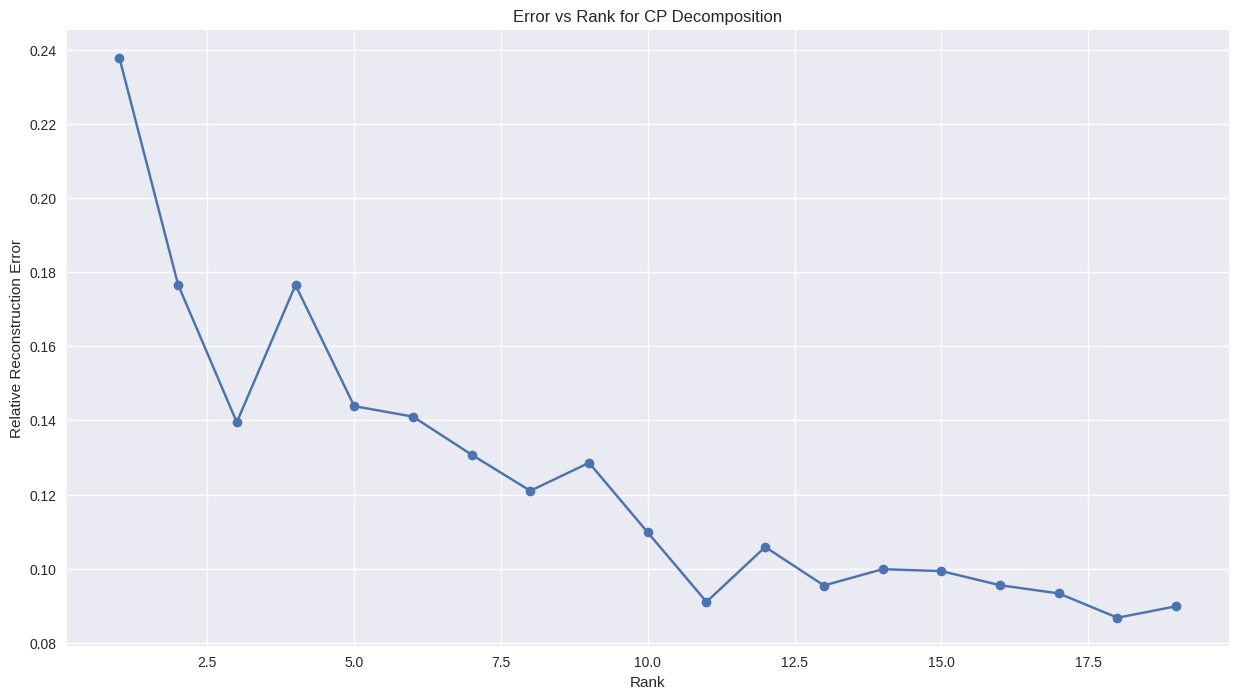

In [87]:
factors_normal_list = []
error_list = []
rank_list=[]
# Test ranks from 1 to 100
for rank in range(1,20):
    factors_normal = parafac(tensor_normal, rank=rank, init='random',random_state=52, n_iter_max=100,l2_reg=1e-8)
    factors_normal_list.append(factors_normal)

    # Reconstruction
    reconstruction = cp_to_tensor(factors_normal)
    error = tl.norm(tensor_normal - reconstruction) / tl.norm(tensor_normal)
    error_list.append(error.item())
    rank_list.append(rank)
    print(f"✅ Rank : {rank}, Error : {error.item():.4f}")

# Plot Error vs. Rank
plt.figure(figsize=(15, 8))
plt.plot(rank_list, error_list, marker='o')
plt.xlabel('Rank')
plt.ylabel('Relative Reconstruction Error')
plt.title('Error vs Rank for CP Decomposition')
plt.grid(True)
plt.show()

**Normal Projection**

In [88]:
def normal_space_projection(tensor_input, tensor_ref):
    # Extract CP factors from reference
    _, (A_ref, B_ref, C_ref, D_ref) = tensor_ref
    rank = A_ref.shape[1]

    # Ensure tensors are on the correct device and dtype
    device = tensor_input.device
    tensor_input = tensor_input.to(torch.float32).to(device)
    B_ref = B_ref.to(torch.float32).to(device)
    C_ref = C_ref.to(torch.float32).to(device)
    D_ref = D_ref.to(torch.float32).to(device)

    # Compute Khatri-Rao product of the normalized factors
    kr_product = tl.tenalg.khatri_rao([D_ref, tl.tenalg.khatri_rao([C_ref, B_ref])])
    kr_pinv = torch.linalg.pinv(kr_product.T)  # Shape: (rank, I*J*K)

    # Project each time slice onto the latent space
    T = tensor_input.shape[0]
    A_proj = torch.zeros((T, rank), dtype=torch.float32, device=device)

    for t in range(T):
        x_vec = tensor_input[t].reshape(1, -1)  # Shape: (1, I*J*K)
        A_proj[t] = x_vec @ kr_pinv  # Shape: (1, rank)

    # Reconstruct the projected tensor using lambdas_ref
    projected_tensor = cp_to_tensor((None, [A_proj, B_ref, C_ref, D_ref]))

    # Compute residual
    residual = tensor_input - projected_tensor

    print("✅ Projection completed.")
    print("Residual norm:", tl.norm(residual).item())

    return residual

In [89]:
residuals_train_list=[]
for factors_normal in factors_normal_list:
    residuals_train= normal_space_projection(tensor_train, factors_normal)
    residuals_train_list.append(residuals_train)
    error_train=tl.norm(residuals_train)/tl.norm(tensor_train)
    print("✅ Residual calculé.")
    print("✅ Rank :",tensor_train[0].shape[0])
    print("✅ Error :",error_train.item())

✅ Projection completed.
Residual norm: 95259.09375
✅ Residual calculé.
✅ Rank : 822
✅ Error : 1.0000016689300537
✅ Projection completed.
Residual norm: 95259.09375
✅ Residual calculé.
✅ Rank : 822
✅ Error : 1.0000016689300537
✅ Projection completed.
Residual norm: 95259.09375
✅ Residual calculé.
✅ Rank : 822
✅ Error : 1.0000016689300537
✅ Projection completed.
Residual norm: 95258.9296875
✅ Residual calculé.
✅ Rank : 822
✅ Error : 1.0
✅ Projection completed.
Residual norm: 95258.9375
✅ Residual calculé.
✅ Rank : 822
✅ Error : 1.0000001192092896
✅ Projection completed.
Residual norm: 95258.9296875
✅ Residual calculé.
✅ Rank : 822
✅ Error : 1.0
✅ Projection completed.
Residual norm: 95258.9296875
✅ Residual calculé.
✅ Rank : 822
✅ Error : 1.0
✅ Projection completed.
Residual norm: 95258.9375
✅ Residual calculé.
✅ Rank : 822
✅ Error : 1.0000001192092896
✅ Projection completed.
Residual norm: 95258.9296875
✅ Residual calculé.
✅ Rank : 822
✅ Error : 1.0
✅ Projection completed.
Residual norm

# AGGREGATION_SCORING

In [90]:
def aggregation_scoring_Source(residuals, mappings, df_with_labels, window_size=300):
    print("⏳ Étape 4 : Aggrégation des scores avec labels...")

    # 1. Convertir relative_time -> time_window (entier)
    df_with_labels = df_with_labels.copy()
    df_with_labels['time_window'] = df_with_labels['relative_time'].astype(np.int64) // (10**9 * window_size)

    # 2. Créer le mapping des labels (Dst IP, time_window) -> label
    label_map = {}
    for _, row in df_with_labels.iterrows():
        key = (row['Dst IP'], int(row['time_window']))
        label = int(row['label']) if pd.notnull(row['label']) else 0
        label_map[key] = max(label_map.get(key, 0), label)

    # 3. Préparer les dimensions
    residuals_np = tl.to_numpy(residuals)
    idx_to_dst_ip = {idx: ip for ip, idx in mappings['Dst_IP'].items()}
    idx_to_feature = {idx: feat for idx, feat in mappings['features_names'].items()}
    time_dim, _, dst_dim, feat_dim = residuals_np.shape

    # 4. Construire la liste des time_windows à partir de l’index
    time_windows = list(range(time_dim))

    # 5. Aggrégation + étiquetage
    aggregation = {}
    for t in range(time_dim):
        time_window = time_windows[t]
        for d in range(dst_dim):
            # Check if the index 'd' exists in idx_to_dst_ip
            if d in idx_to_dst_ip:
                dst_ip = idx_to_dst_ip[d]
                key = (dst_ip, time_window)

                if key not in aggregation:
                    aggregation[key] = {
                        'Dst IP': dst_ip,
                        'time_windows': time_window,
                        'count': 0,
                        'bytes': 0,
                        'packets': 0,
                        'duration': 0,
                        'label': label_map.get(key, 0)  # label ajouté ici
                    }

                for f in range(feat_dim):
                    feature_name = idx_to_feature[f].lower()
                    score = np.sum(np.abs(residuals_np[t, :, d, f]))

                    if 'count' in feature_name:
                        aggregation[key]['count'] += score
                    elif 'bytes' in feature_name:
                        aggregation[key]['bytes'] += score
                    elif 'packets' in feature_name:
                        aggregation[key]['packets'] += score
                    elif 'duration' in feature_name:
                        aggregation[key]['duration'] += score
            else:
                continue

    df_scores = pd.DataFrame(list(aggregation.values()))

    #log_step("Étape 4", start)
    print("✅ Aggrégation des scores + labels terminée.")

    return df_scores

In [91]:
mappings={'Dst_IP':dst_ip_to_idx,'features_names':dict(enumerate(['count','bytes','packets','duration']))}

In [92]:
df_train_list=[]
i=0
for residuals_train in residuals_train_list:
        df_scores_train=aggregation_scoring_Source(residuals_train,mappings, df_train, window_size=300)
        df_train_list.append(df_scores_train)
        print("shape=",df_scores_train.shape)
        print("df added",i)
        i=i+1

⏳ Étape 4 : Aggrégation des scores avec labels...
✅ Aggrégation des scores + labels terminée.
shape= (15756, 7)
df added 0
⏳ Étape 4 : Aggrégation des scores avec labels...
✅ Aggrégation des scores + labels terminée.
shape= (15756, 7)
df added 1
⏳ Étape 4 : Aggrégation des scores avec labels...
✅ Aggrégation des scores + labels terminée.
shape= (15756, 7)
df added 2
⏳ Étape 4 : Aggrégation des scores avec labels...
✅ Aggrégation des scores + labels terminée.
shape= (15756, 7)
df added 3
⏳ Étape 4 : Aggrégation des scores avec labels...
✅ Aggrégation des scores + labels terminée.
shape= (15756, 7)
df added 4
⏳ Étape 4 : Aggrégation des scores avec labels...
✅ Aggrégation des scores + labels terminée.
shape= (15756, 7)
df added 5
⏳ Étape 4 : Aggrégation des scores avec labels...
✅ Aggrégation des scores + labels terminée.
shape= (15756, 7)
df added 6
⏳ Étape 4 : Aggrégation des scores avec labels...
✅ Aggrégation des scores + labels terminée.
shape= (15756, 7)
df added 7
⏳ Étape 4 : Aggr

In [93]:
def build_and_train_binary_classifier(X_train, y_train, X_test, y_test, learning_rate=0.0001, batch_size=32, epochs=50):
    input_dim = X_train.shape[1]

    # Définition du modèle
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation='sigmoid'),
        layers.Dense(80, activation='sigmoid'),
        layers.Dense(80, activation='sigmoid'),
        layers.Dense(32, activation='sigmoid'),
        layers.Dense(32, activation='sigmoid'),
        layers.Dropout(0.3),
        layers.Dense(64, activation='sigmoid'),
        layers.Dropout(0.2),
        layers.Dense(32, activation='sigmoid'),
        layers.Dropout(0.2),
        layers.Dense(1, activation='sigmoid')

    ])

    # Compilation
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC()]
    )


    # Entraînement
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        batch_size=batch_size, # Reduced batch size
        epochs=epochs,
        verbose=1
    )

    return model, history

In [94]:
model_list=[]
i=0
features=['count','packets','duration','bytes']
def remove_outliers_iqr(df, features):
    cleaned_df = df.copy()
    for col in features:
        Q1 = cleaned_df[col].quantile(0.25)
        Q3 = cleaned_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Filtrer les lignes en fonction de la colonne actuelle
        cleaned_df = cleaned_df[(cleaned_df[col] >= lower_bound) & (cleaned_df[col] <= upper_bound)]
    return cleaned_df
for df in df_train_list:
        remove=remove_outliers_iqr(df[df['label']==0], features)
        df_cleaned=pd.concat([remove,df[df['label']==1]],axis=0)
        X=scaled.fit_transform(df_cleaned.drop(columns=['label','Dst IP','time_windows']))
        Y=df_cleaned['label']
        X1_train,X1_test,Y1_train,Y1_test = train_test_split(X,Y,test_size=0.3,stratify=Y)
        model,history=build_and_train_binary_classifier(X1_train, Y1_train, X1_test, Y1_test)
        model_list.append(model)
        print("model",i)

Epoch 1/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - accuracy: 0.2803 - auc_19: 0.4977 - loss: 0.9259 - val_accuracy: 0.8904 - val_auc_19: 0.5000 - val_loss: 0.4488
Epoch 2/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8846 - auc_19: 0.5011 - loss: 0.4291 - val_accuracy: 0.8904 - val_auc_19: 0.5000 - val_loss: 0.3562
Epoch 3/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8933 - auc_19: 0.4909 - loss: 0.3629 - val_accuracy: 0.8904 - val_auc_19: 0.5000 - val_loss: 0.3463
Epoch 4/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8854 - auc_19: 0.5097 - loss: 0.3656 - val_accuracy: 0.8904 - val_auc_19: 0.5000 - val_loss: 0.3457
Epoch 5/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8935 - auc_19: 0.5048 - loss: 0.3485 - val_accuracy: 0.8904 - val_auc_19: 0.5000 - val_loss: 0.3460
Epoch 6/50
295/295 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8964 - auc_19: 0.4870 - loss: 0.3439 - val_accuracy: 0.8904 - val_auc_19: 0.5000 - val_loss: 0.3459
Epo

# TEST PHASE

In [95]:
residuals_test_list=[]
for factors_normal in factors_normal_list:
    residuals_test = normal_space_projection(tensor_test, factors_normal)
    residuals_test_list.append(residuals_test)
    print("✅ Residual calculé.")

✅ Projection completed.
Residual norm: 29020.82421875
✅ Residual calculé.
✅ Projection completed.
Residual norm: 29020.82421875
✅ Residual calculé.
✅ Projection completed.
Residual norm: 29020.82421875
✅ Residual calculé.
✅ Projection completed.
Residual norm: 29020.791015625
✅ Residual calculé.
✅ Projection completed.
Residual norm: 29020.791015625
✅ Residual calculé.
✅ Projection completed.
Residual norm: 29020.791015625
✅ Residual calculé.
✅ Projection completed.
Residual norm: 29020.791015625
✅ Residual calculé.
✅ Projection completed.
Residual norm: 29020.79296875
✅ Residual calculé.
✅ Projection completed.
Residual norm: 29020.791015625
✅ Residual calculé.
✅ Projection completed.
Residual norm: 29020.791015625
✅ Residual calculé.
✅ Projection completed.
Residual norm: 29020.791015625
✅ Residual calculé.
✅ Projection completed.
Residual norm: 29020.791015625
✅ Residual calculé.
✅ Projection completed.
Residual norm: 29020.791015625
✅ Residual calculé.
✅ Projection completed.
Resid

In [96]:
df_test_list=[]
i=0
for residuals_test in residuals_test_list:
    df_scores_test=aggregation_scoring_Source(residuals_test,mappings, df_test, window_size=300)
    df_test_list.append(df_scores_test)
    print("shape=",df_scores_test.shape)
    print('ok for df ',i)

⏳ Étape 4 : Aggrégation des scores avec labels...
✅ Aggrégation des scores + labels terminée.
shape= (17069, 7)
ok for df  0
⏳ Étape 4 : Aggrégation des scores avec labels...
✅ Aggrégation des scores + labels terminée.
shape= (17069, 7)
ok for df  0
⏳ Étape 4 : Aggrégation des scores avec labels...
✅ Aggrégation des scores + labels terminée.
shape= (17069, 7)
ok for df  0
⏳ Étape 4 : Aggrégation des scores avec labels...
✅ Aggrégation des scores + labels terminée.
shape= (17069, 7)
ok for df  0
⏳ Étape 4 : Aggrégation des scores avec labels...
✅ Aggrégation des scores + labels terminée.
shape= (17069, 7)
ok for df  0
⏳ Étape 4 : Aggrégation des scores avec labels...
✅ Aggrégation des scores + labels terminée.
shape= (17069, 7)
ok for df  0
⏳ Étape 4 : Aggrégation des scores avec labels...
✅ Aggrégation des scores + labels terminée.
shape= (17069, 7)
ok for df  0
⏳ Étape 4 : Aggrégation des scores avec labels...
✅ Aggrégation des scores + labels terminée.
shape= (17069, 7)
ok for df  0


534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


<Figure size 600x500 with 0 Axes>

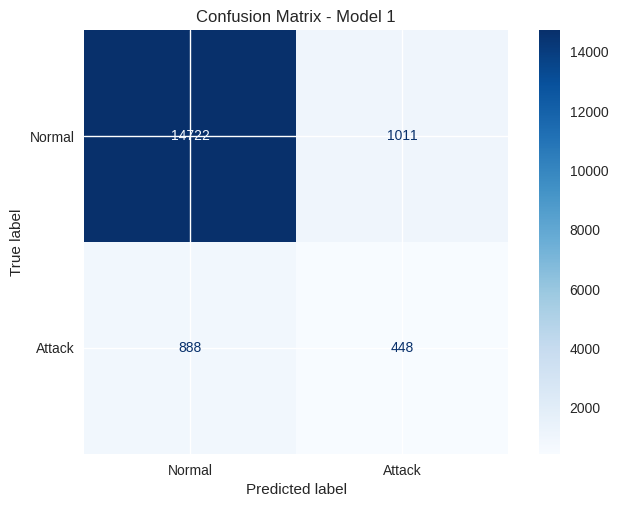

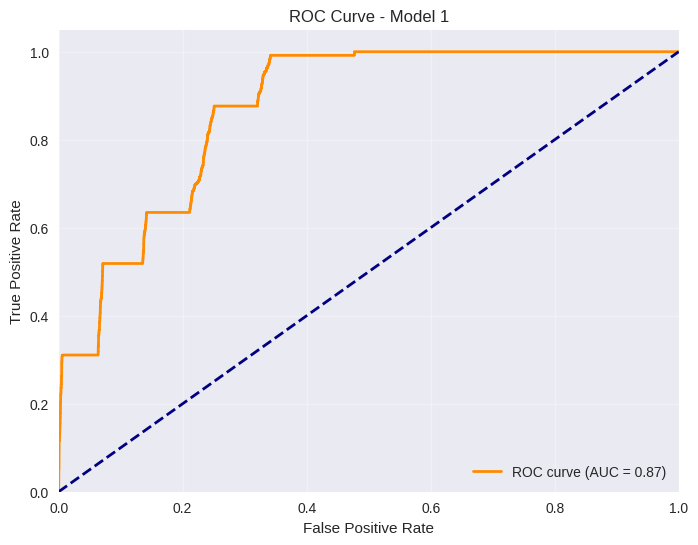

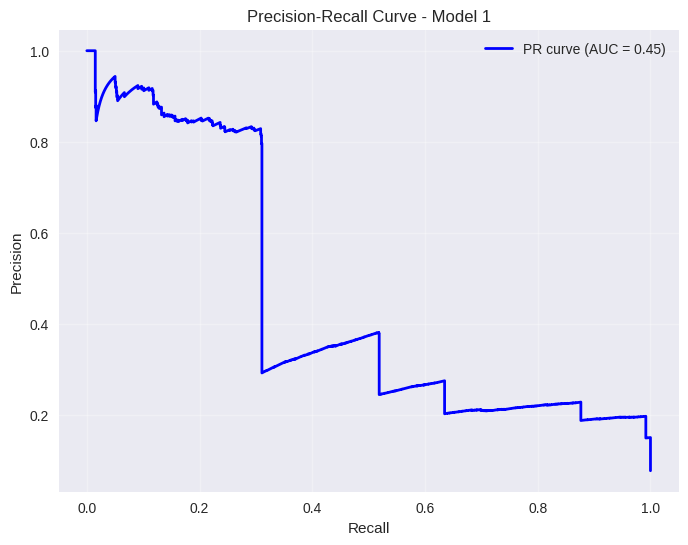

534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


<Figure size 600x500 with 0 Axes>

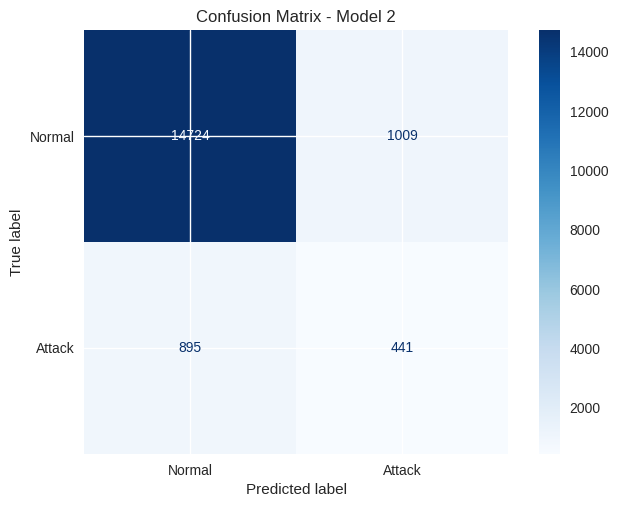

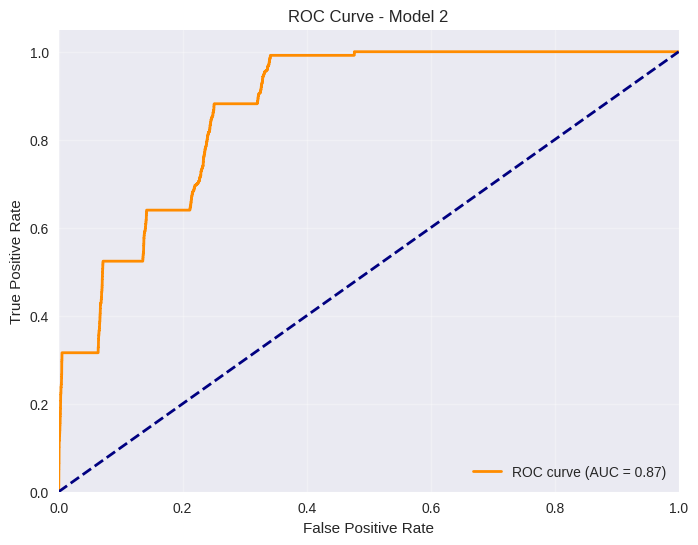

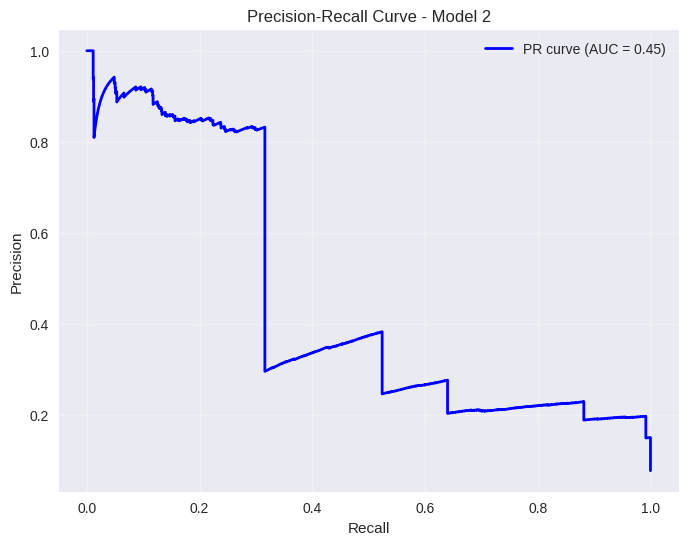

534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


<Figure size 600x500 with 0 Axes>

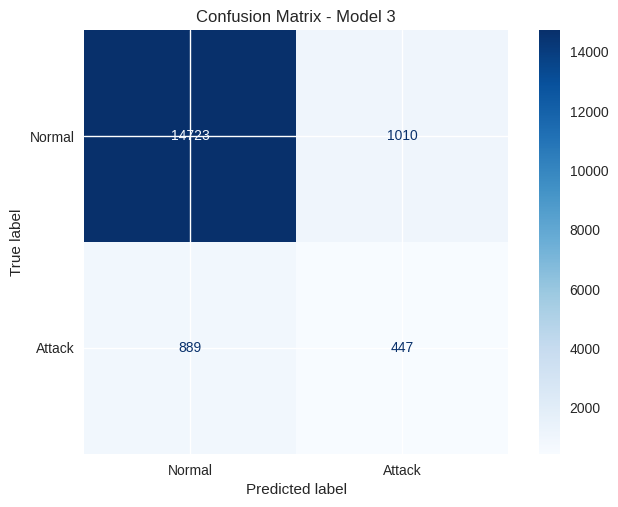

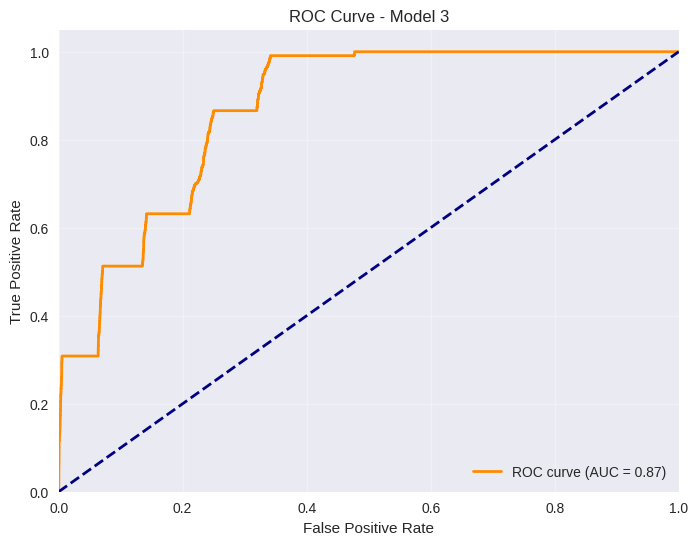

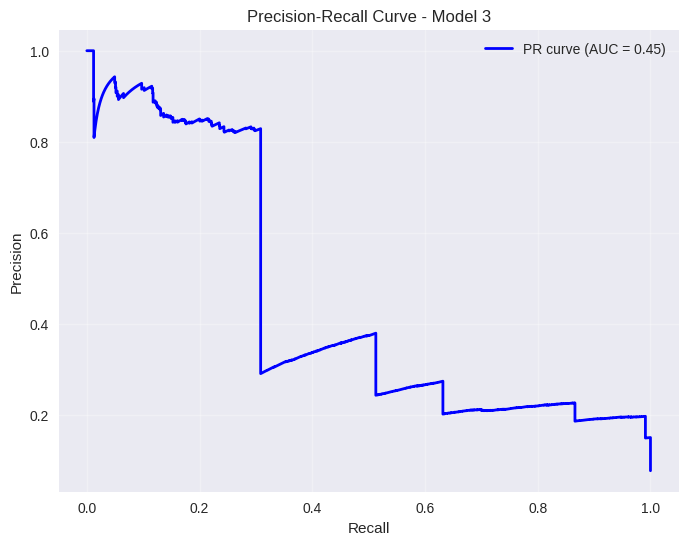

534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


<Figure size 600x500 with 0 Axes>

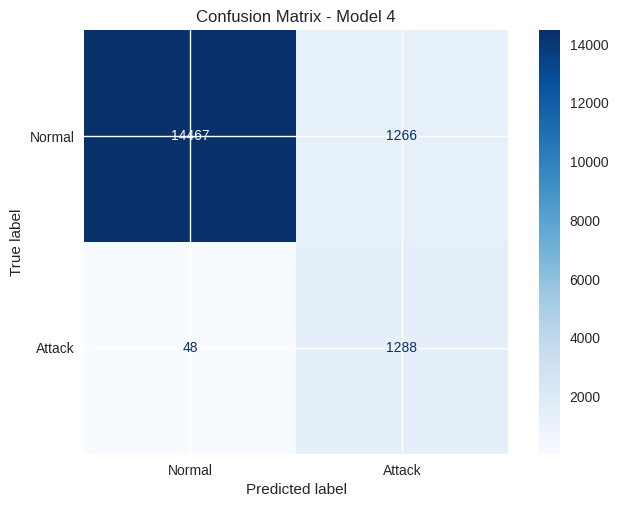

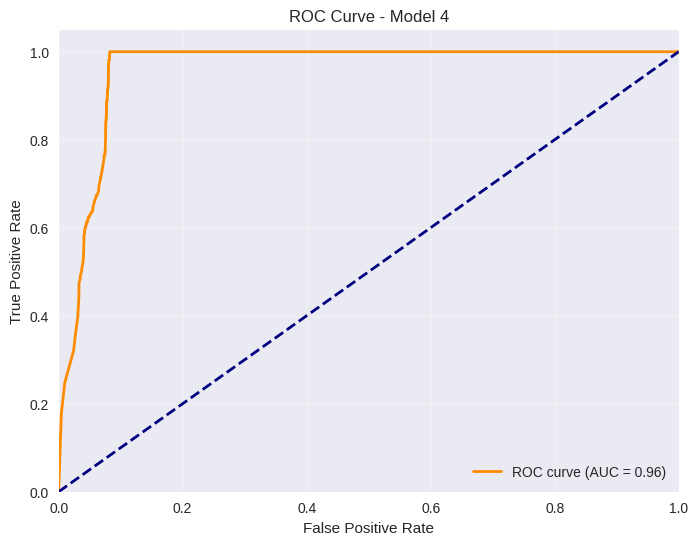

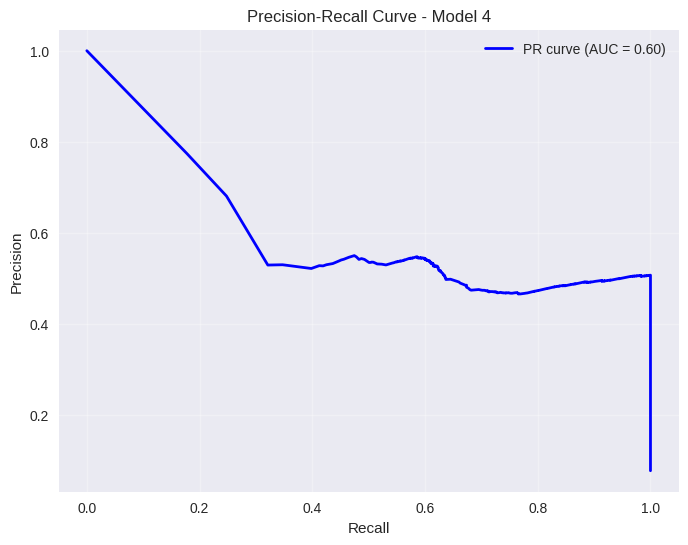

534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


<Figure size 600x500 with 0 Axes>

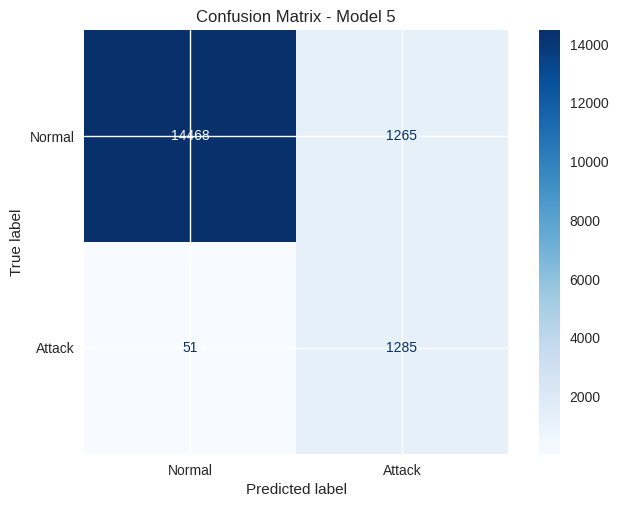

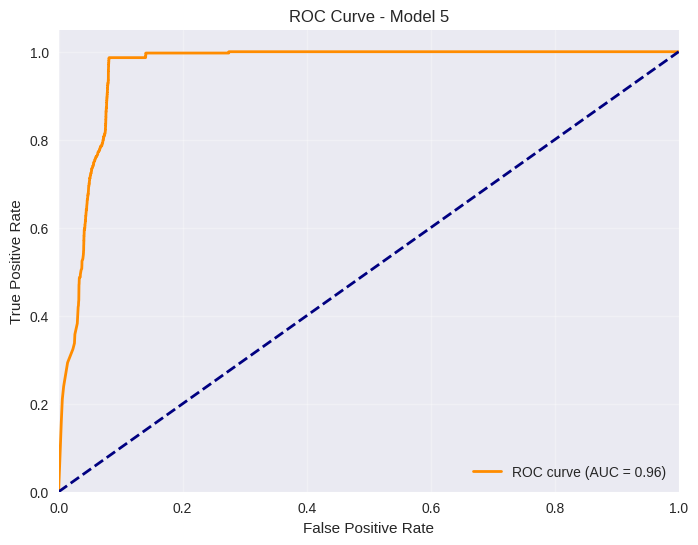

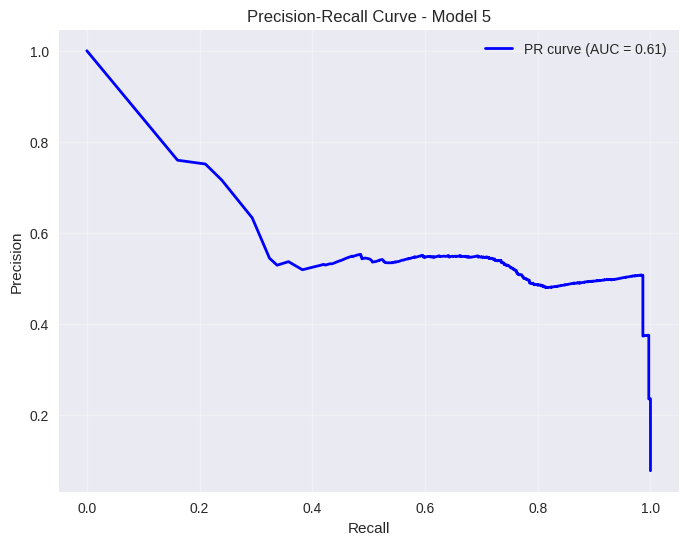

534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


<Figure size 600x500 with 0 Axes>

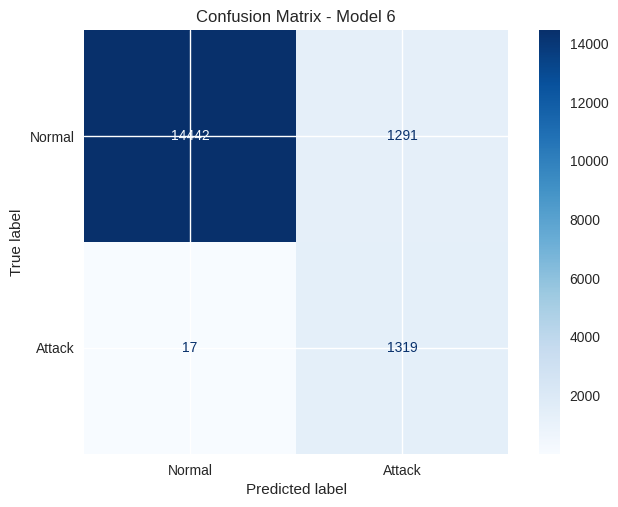

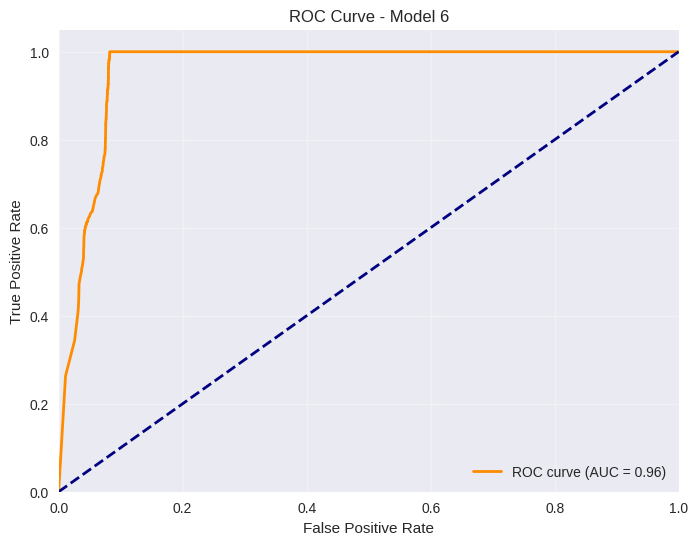

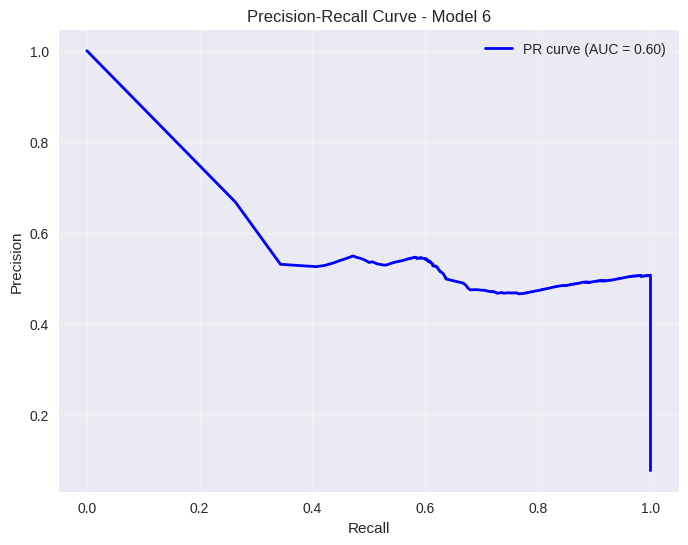

534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


<Figure size 600x500 with 0 Axes>

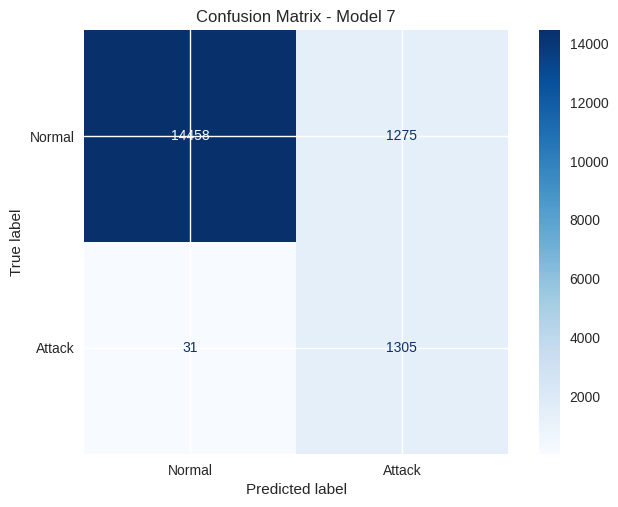

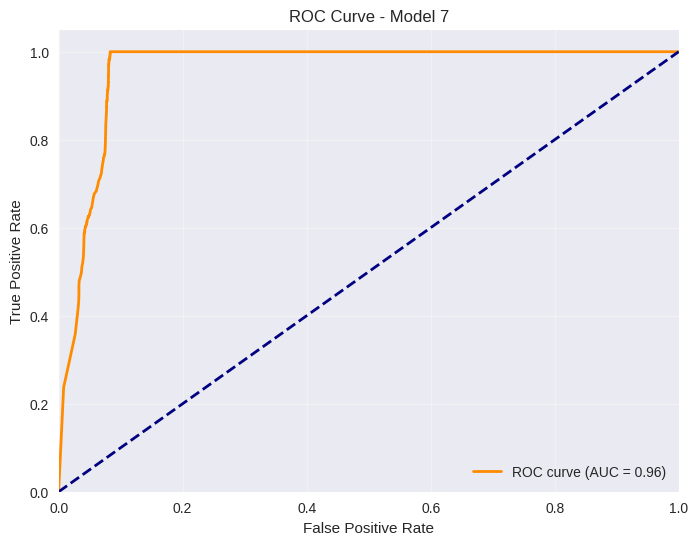

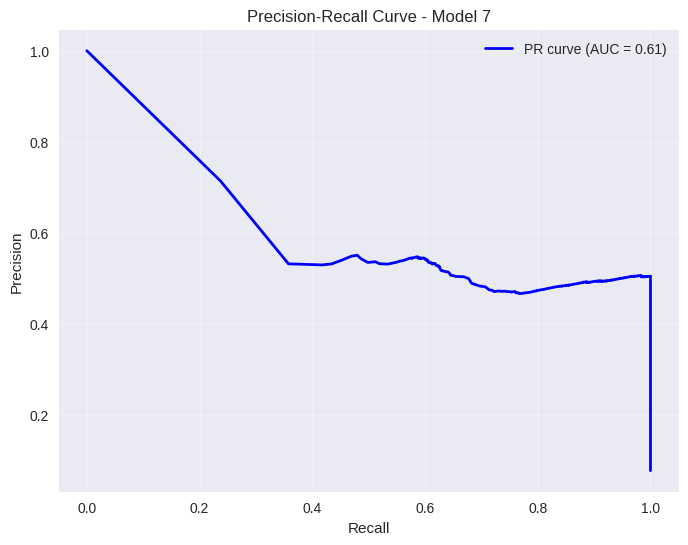

534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


<Figure size 600x500 with 0 Axes>

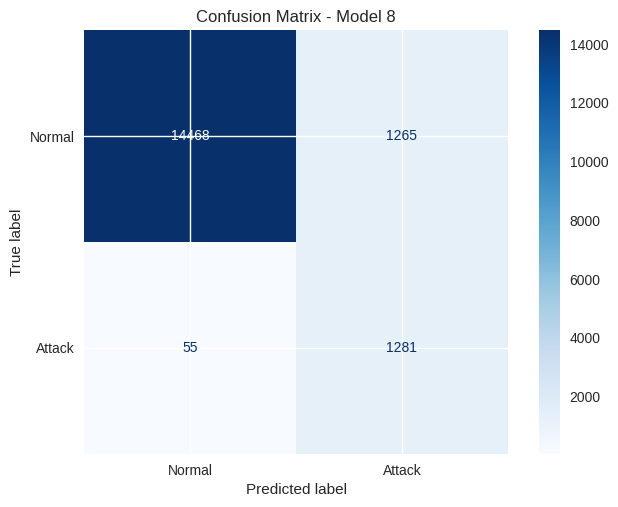

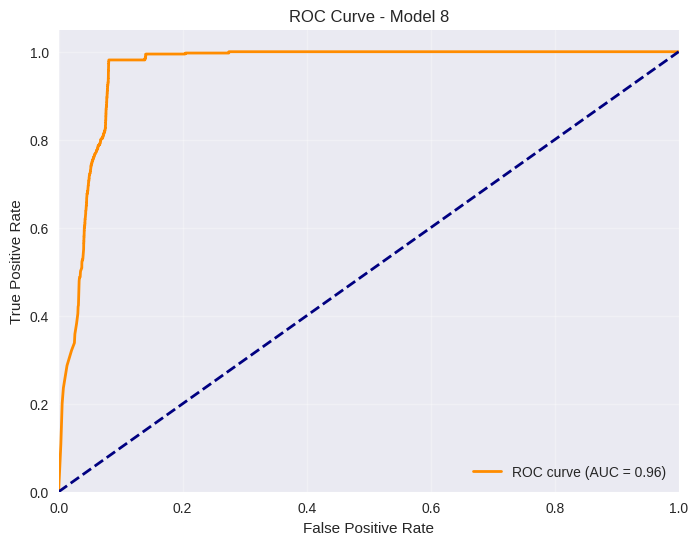

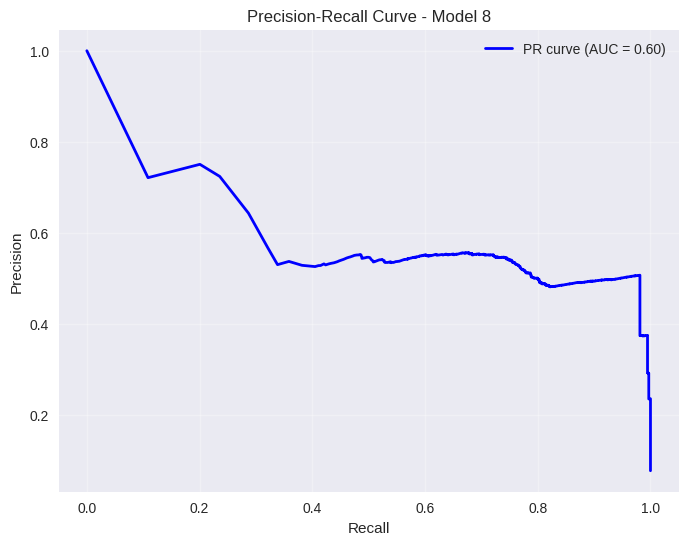

534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


<Figure size 600x500 with 0 Axes>

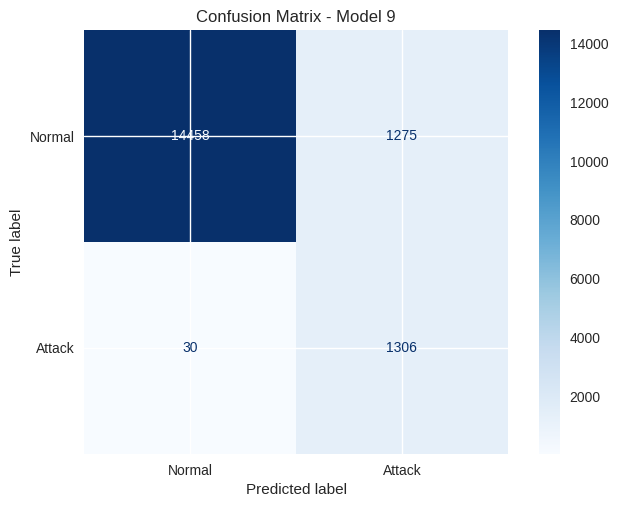

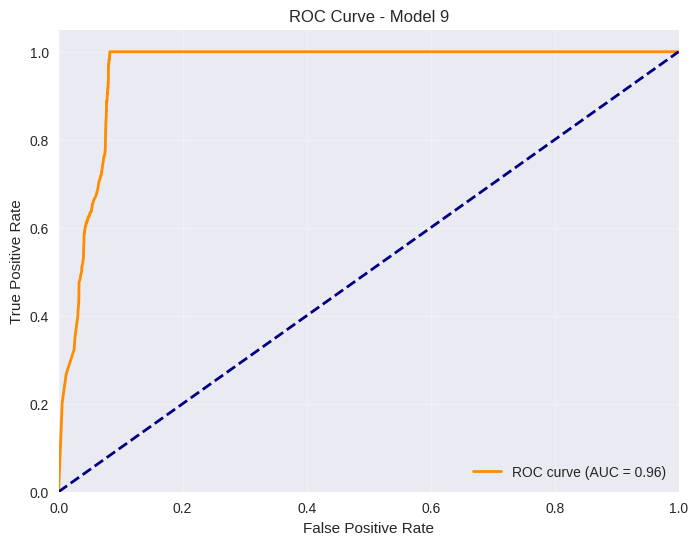

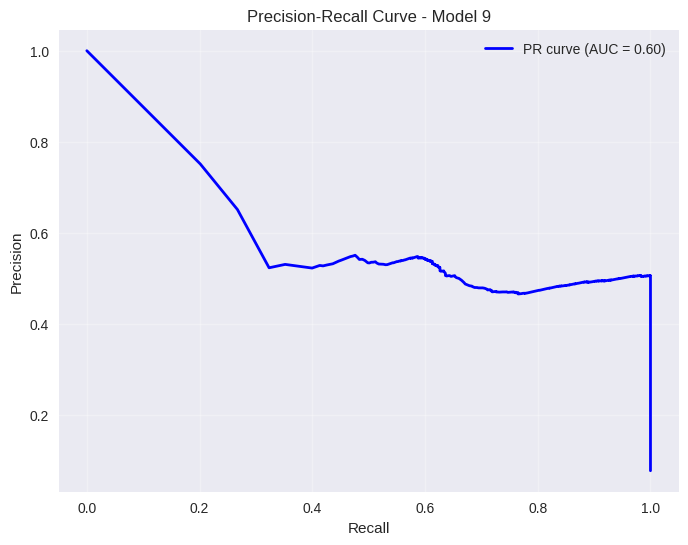

534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


<Figure size 600x500 with 0 Axes>

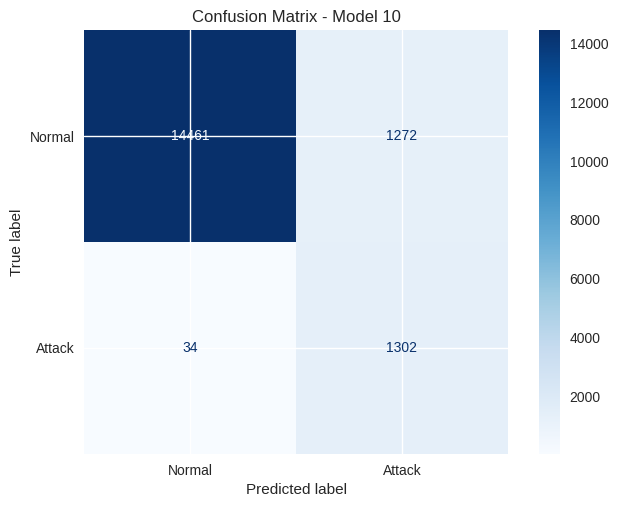

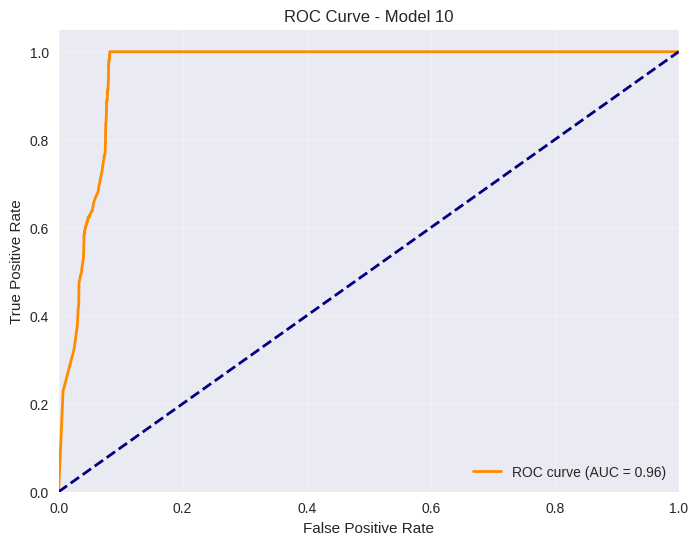

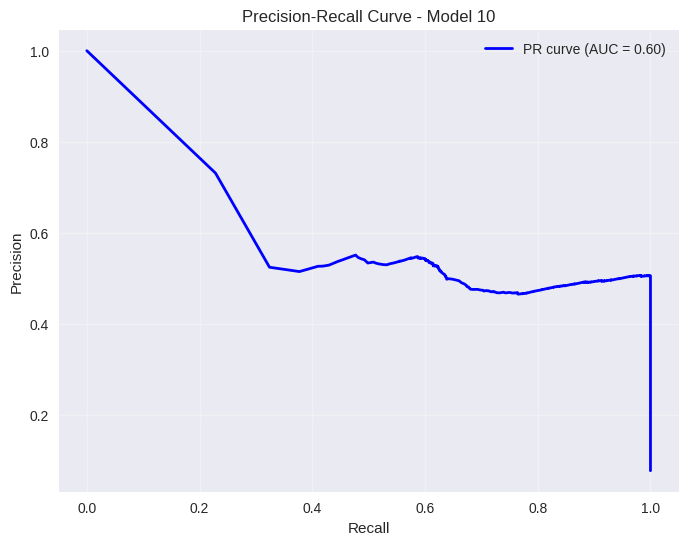

534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


<Figure size 600x500 with 0 Axes>

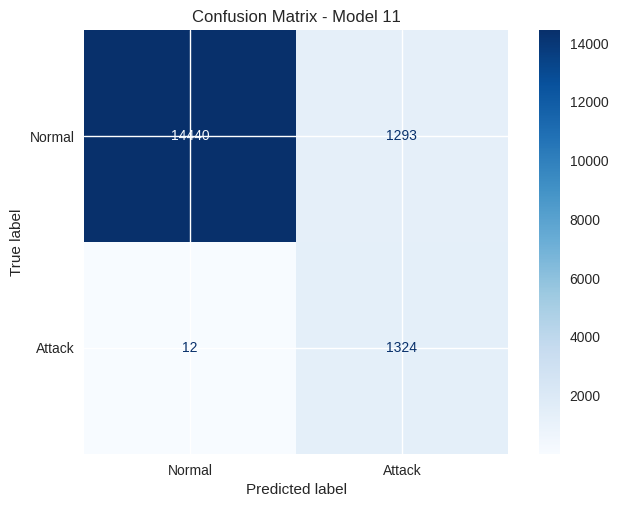

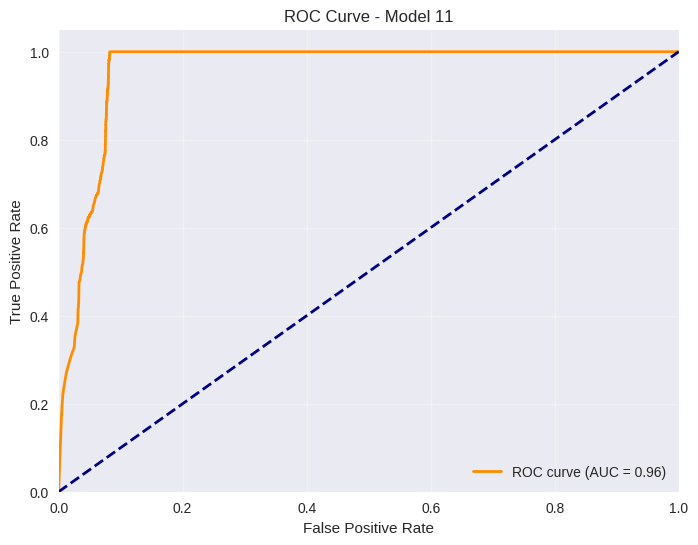

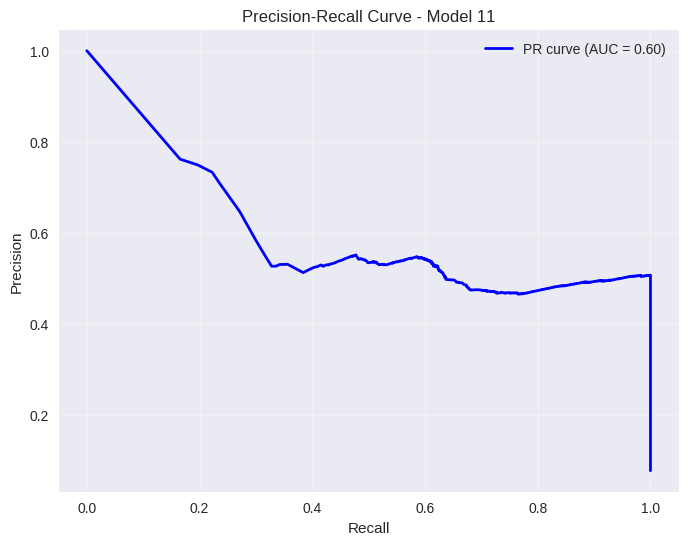

534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


<Figure size 600x500 with 0 Axes>

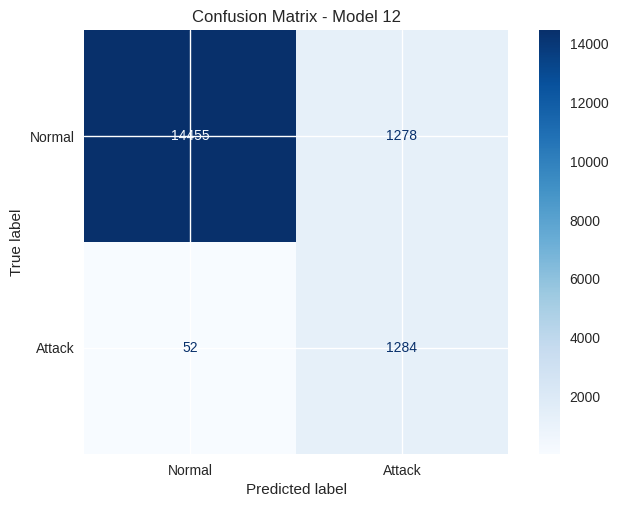

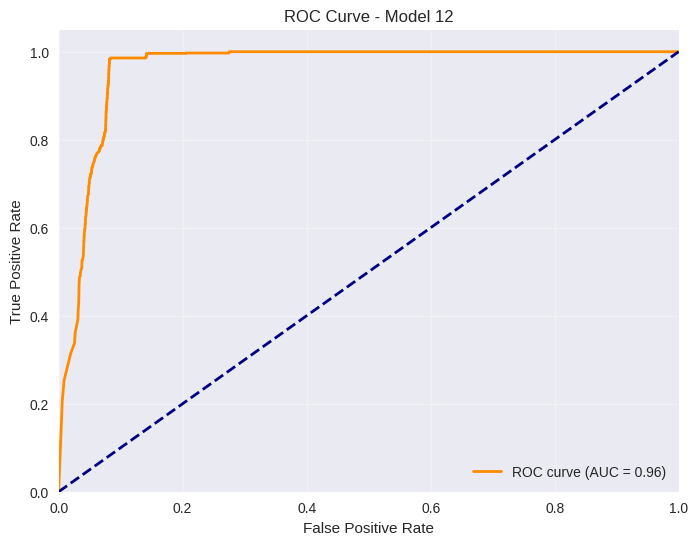

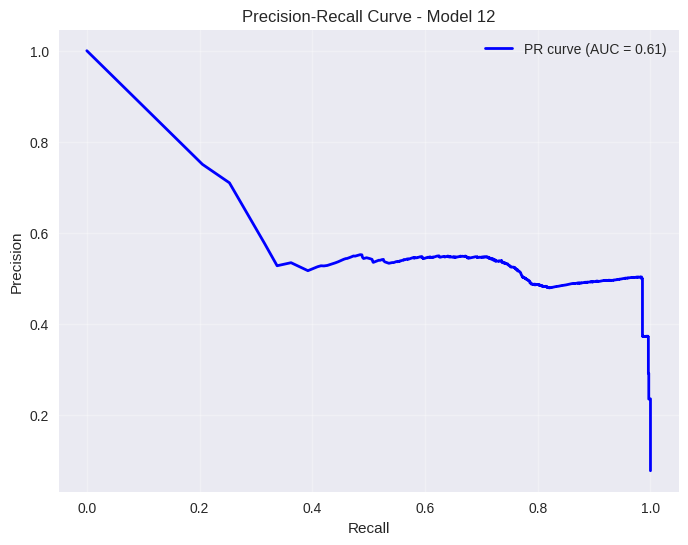

534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


<Figure size 600x500 with 0 Axes>

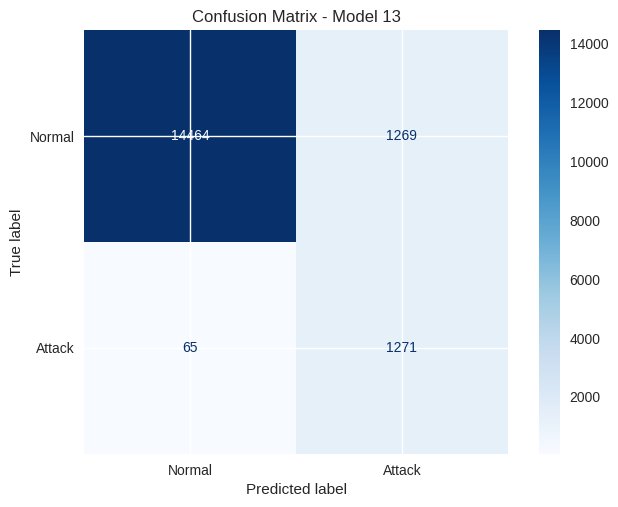

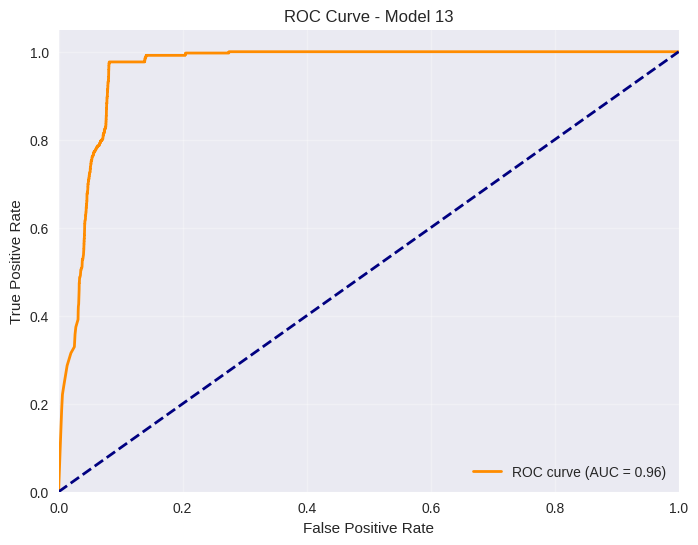

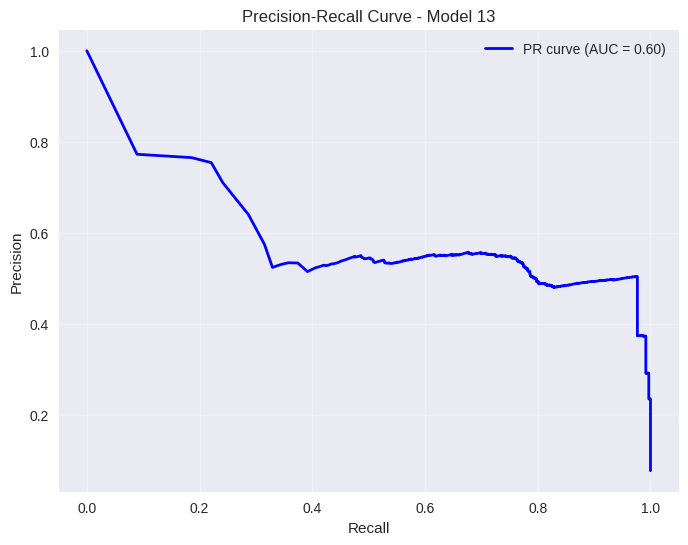

534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


<Figure size 600x500 with 0 Axes>

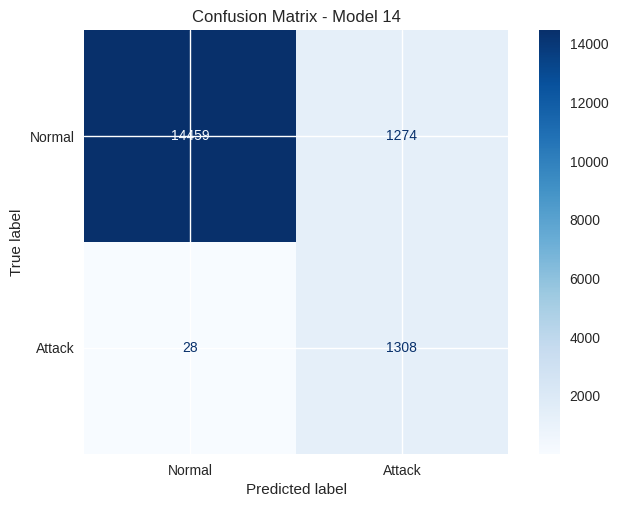

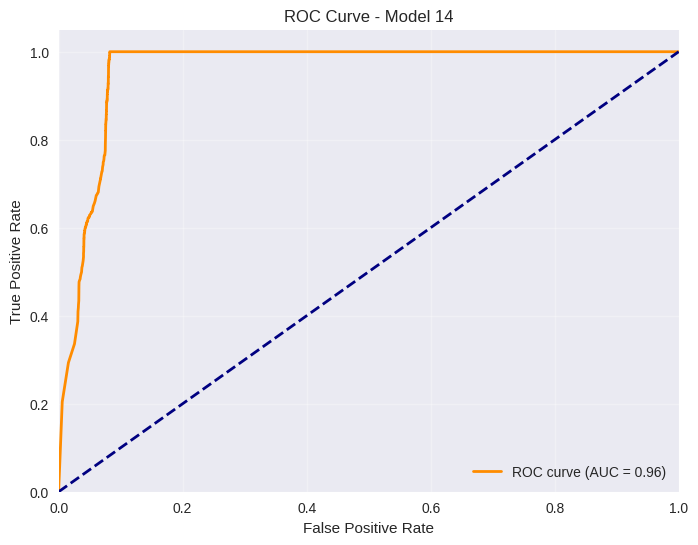

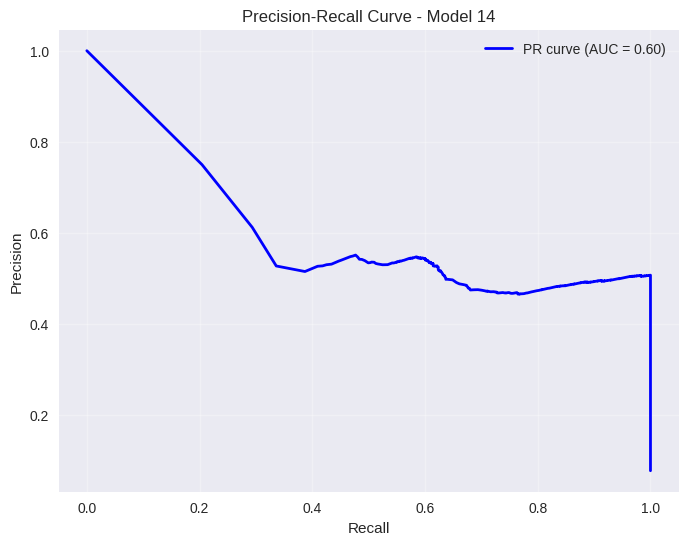

534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


<Figure size 600x500 with 0 Axes>

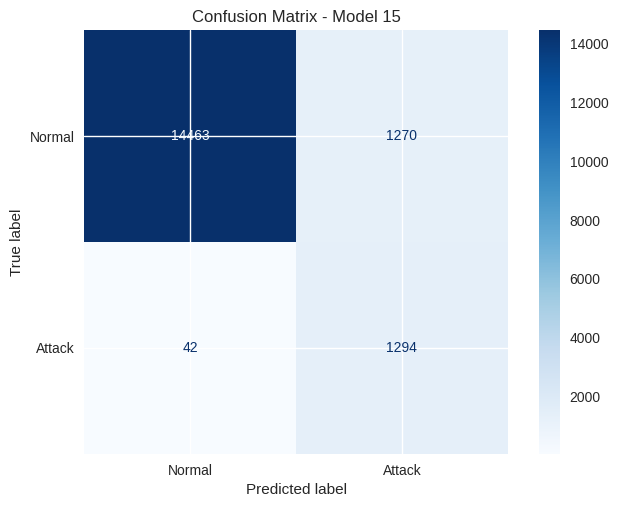

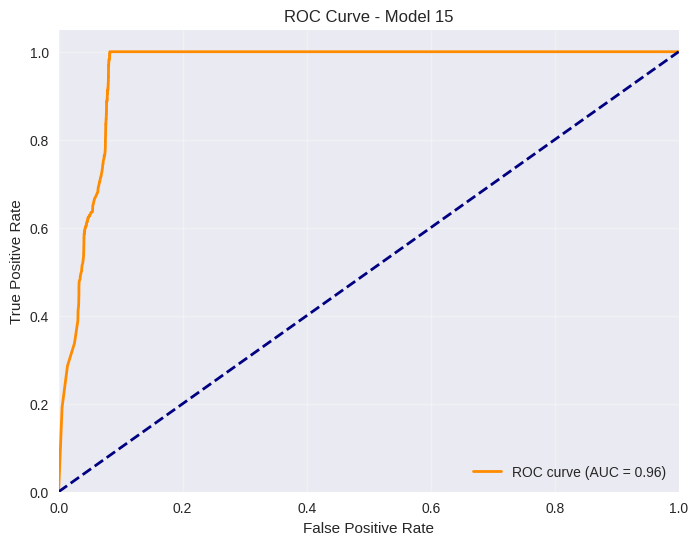

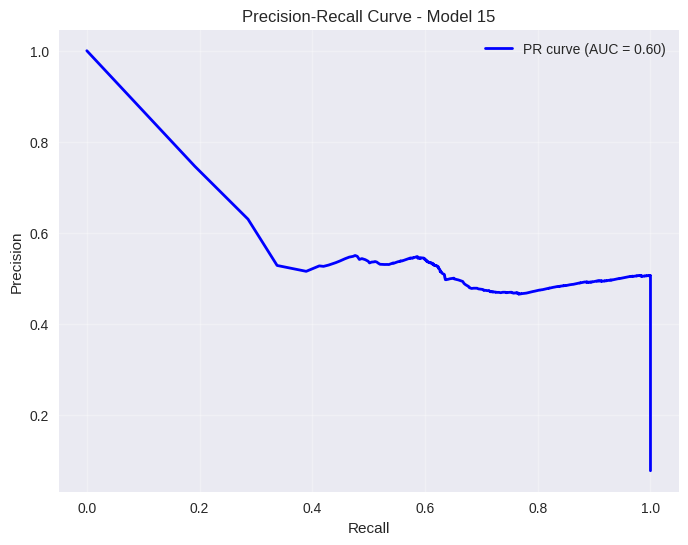

534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


<Figure size 600x500 with 0 Axes>

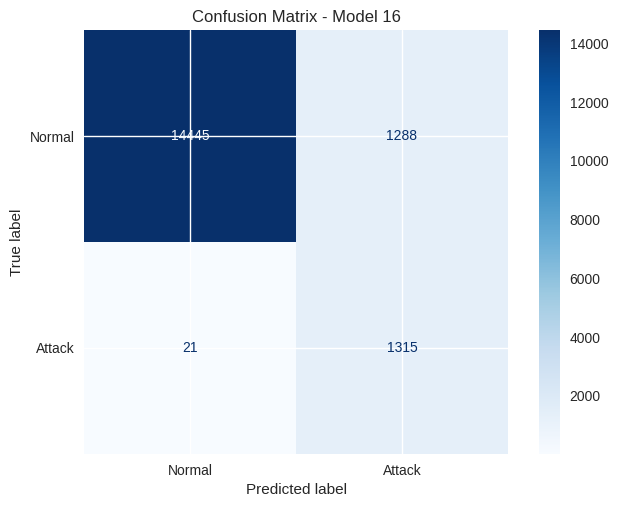

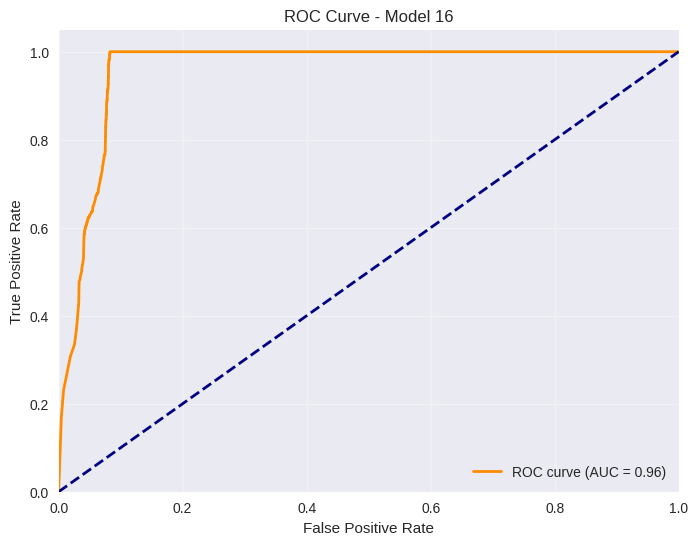

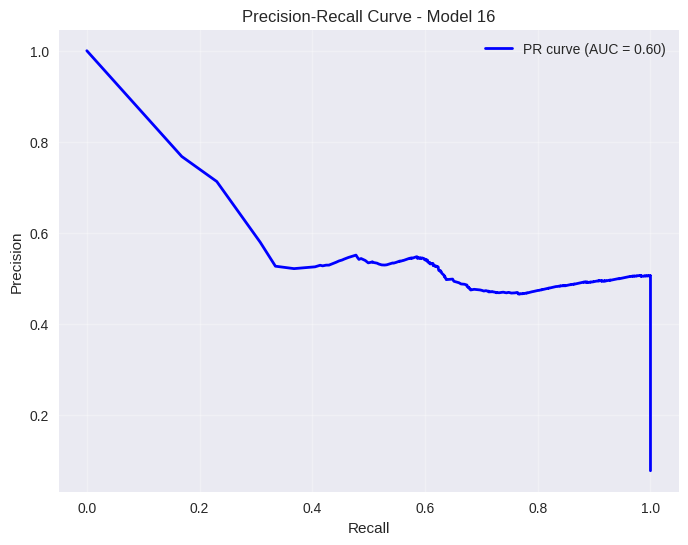

534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


<Figure size 600x500 with 0 Axes>

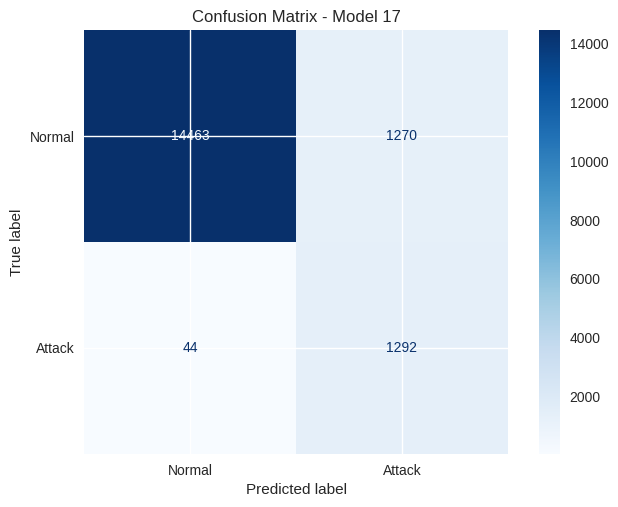

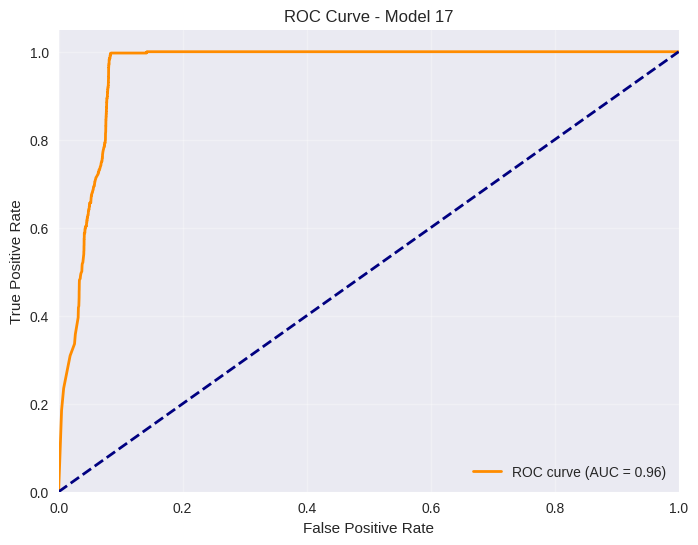

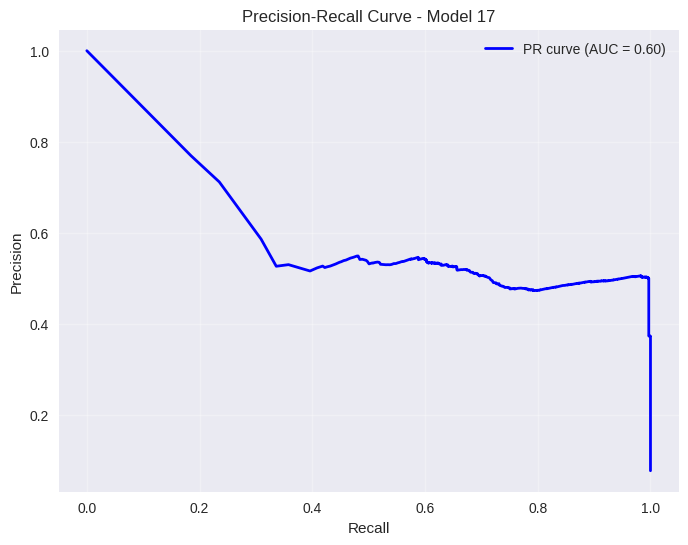

534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


<Figure size 600x500 with 0 Axes>

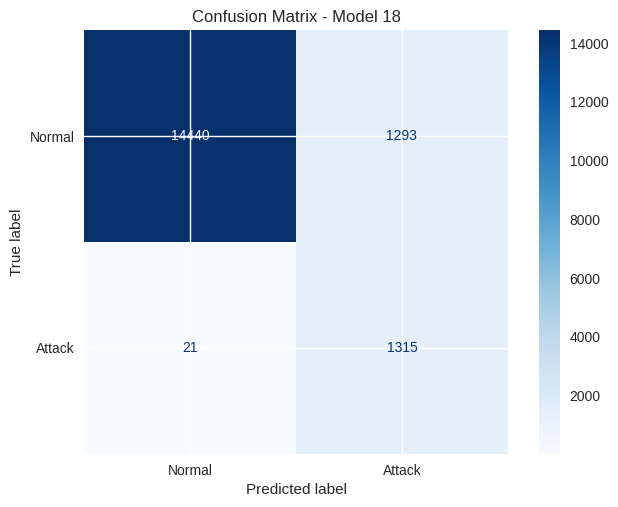

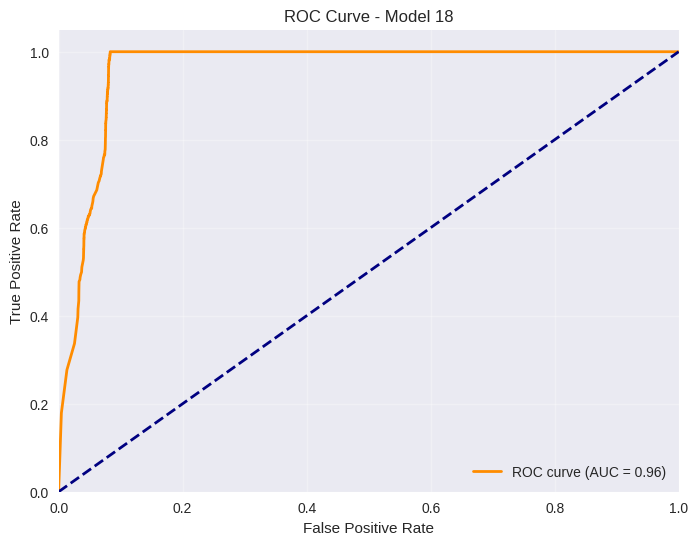

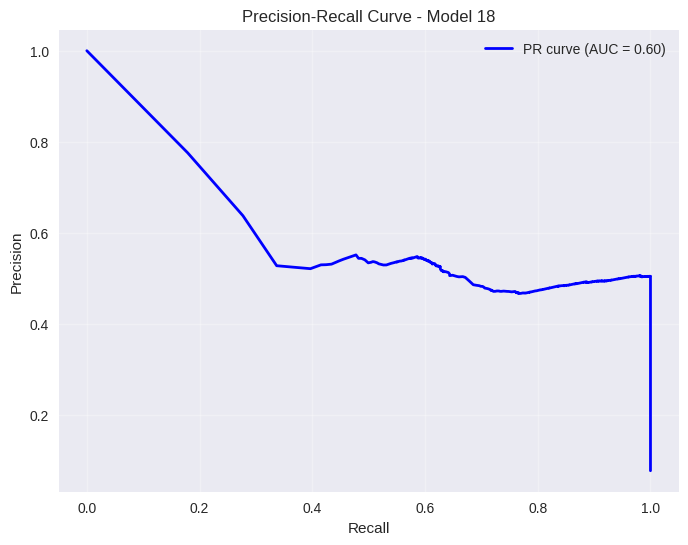

534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


<Figure size 600x500 with 0 Axes>

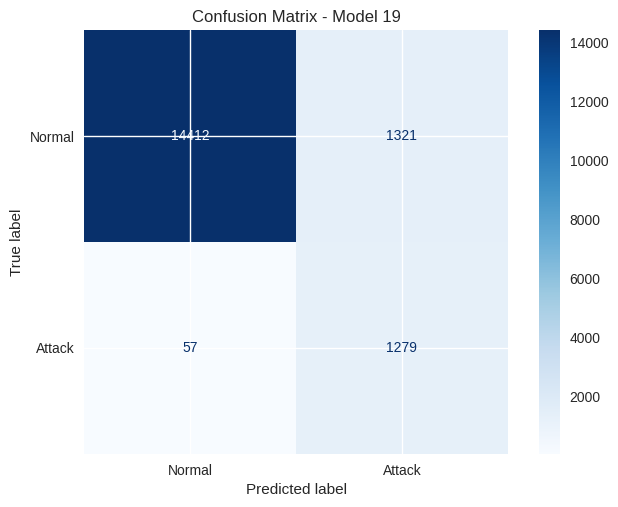

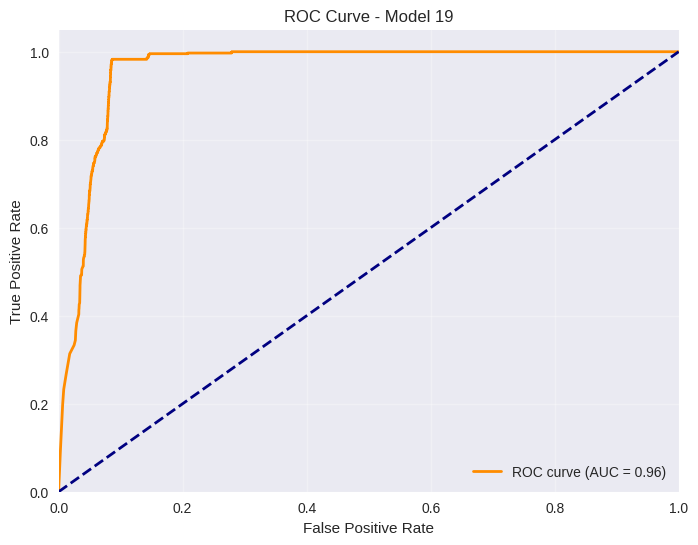

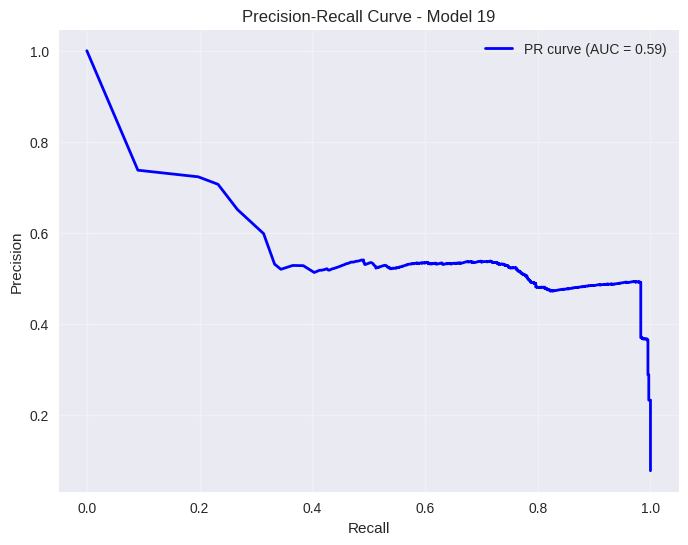

Model Comparison Results:
       Model  Accuracy  Precision  Recall  F1_Score
0    Model_1    0.8887     0.3071  0.3353    0.3206
1    Model_2    0.8885     0.3041  0.3301    0.3166
2    Model_3    0.8887     0.3068  0.3346    0.3201
3    Model_4    0.9230     0.5043  0.9641    0.6622
4    Model_5    0.9229     0.5039  0.9618    0.6613
5    Model_6    0.9234     0.5054  0.9873    0.6685
6    Model_7    0.9235     0.5058  0.9768    0.6665
7    Model_8    0.9227     0.5031  0.9588    0.6600
8    Model_9    0.9235     0.5060  0.9775    0.6668
9   Model_10    0.9235     0.5058  0.9746    0.6660
10  Model_11    0.9235     0.5059  0.9910    0.6699
11  Model_12    0.9221     0.5012  0.9611    0.6588
12  Model_13    0.9218     0.5004  0.9513    0.6558
13  Model_14    0.9237     0.5066  0.9790    0.6677
14  Model_15    0.9231     0.5047  0.9686    0.6636
15  Model_16    0.9233     0.5052  0.9843    0.6677
16  Model_17    0.9230     0.5043  0.9671    0.6629
17  Model_18    0.9230     0.5042  0.9

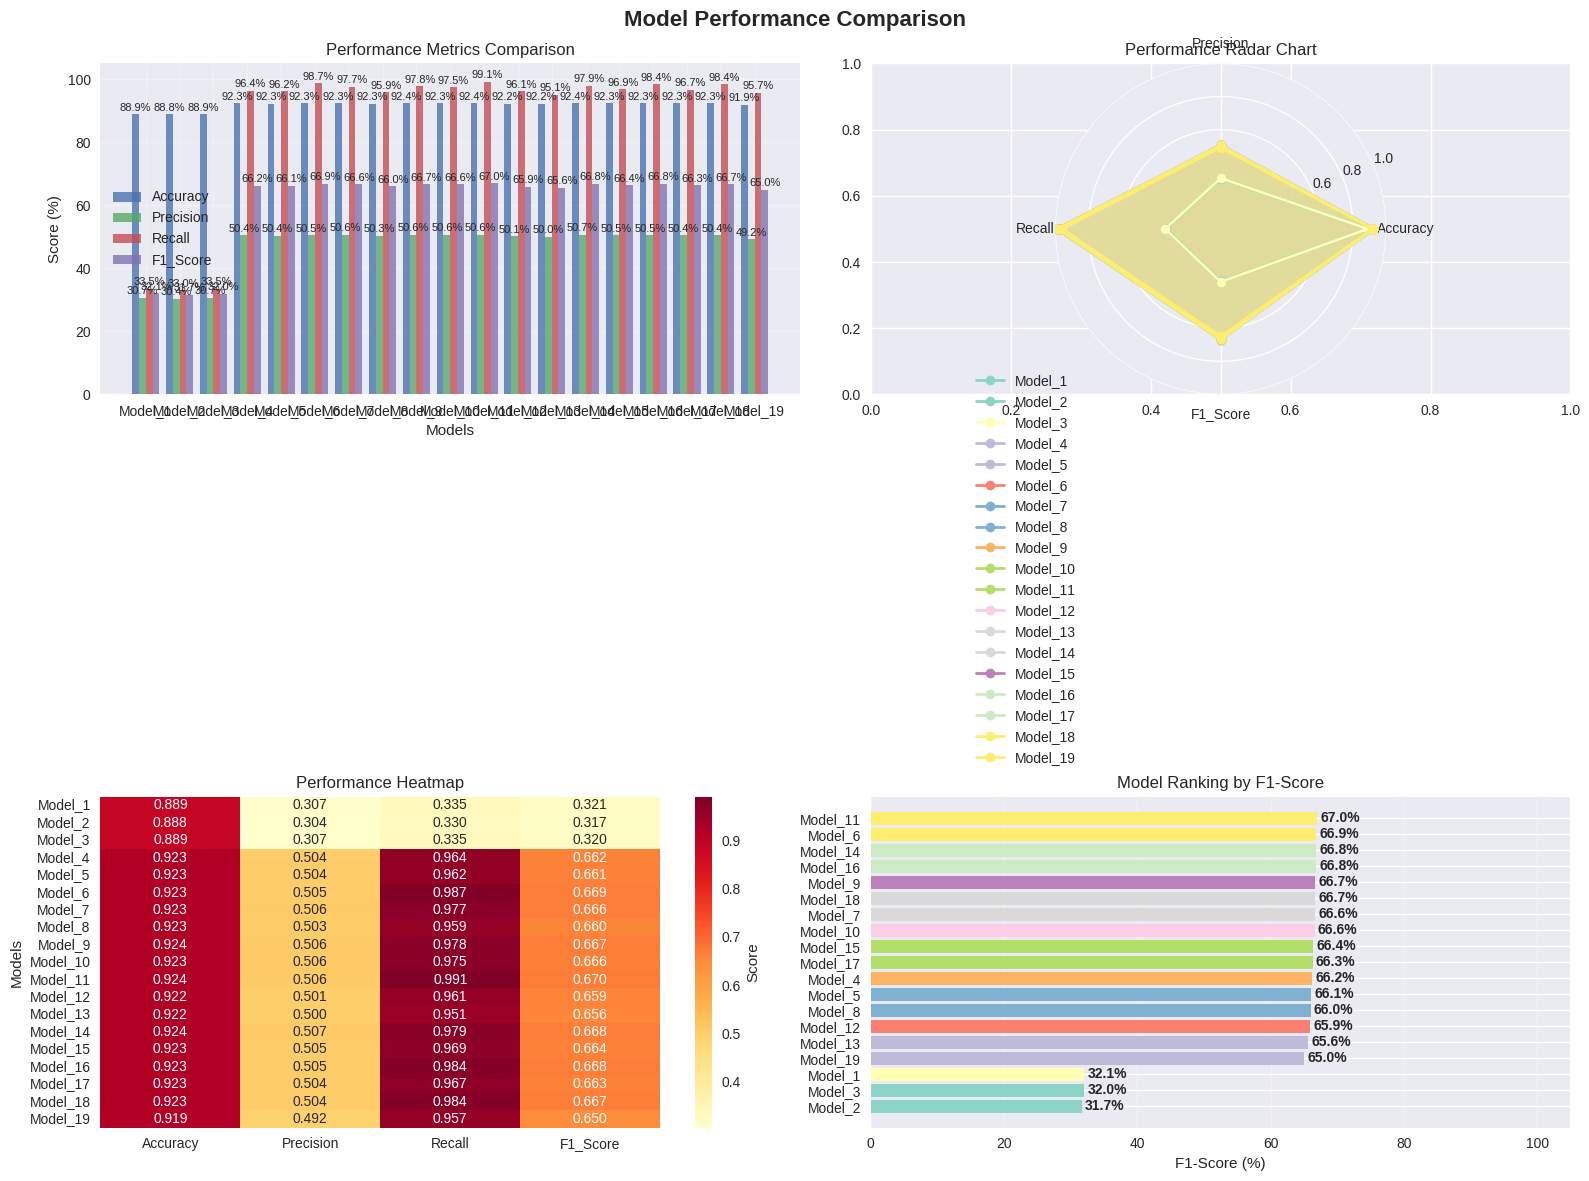

534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


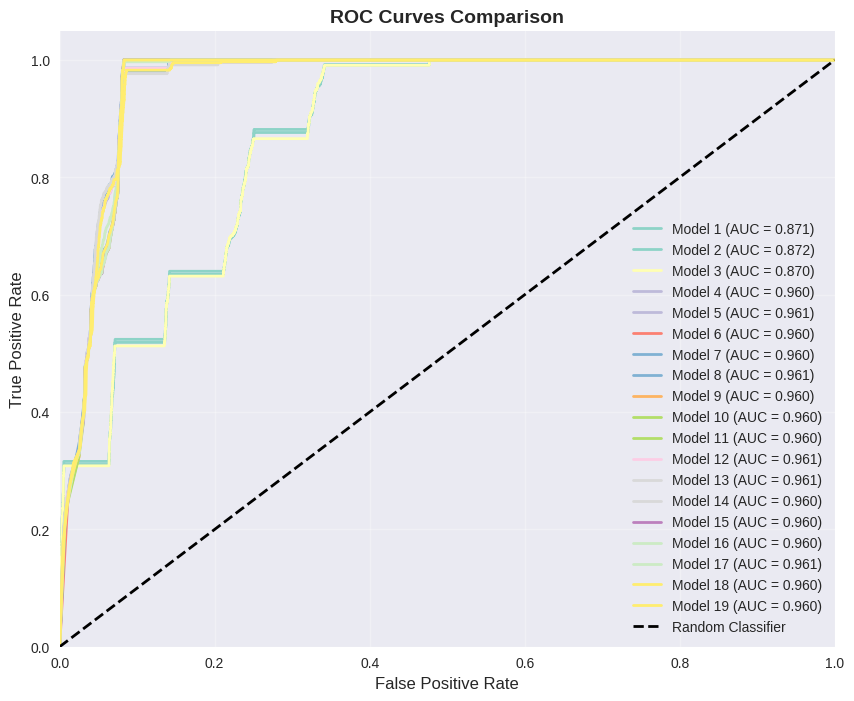

534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
534/534 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


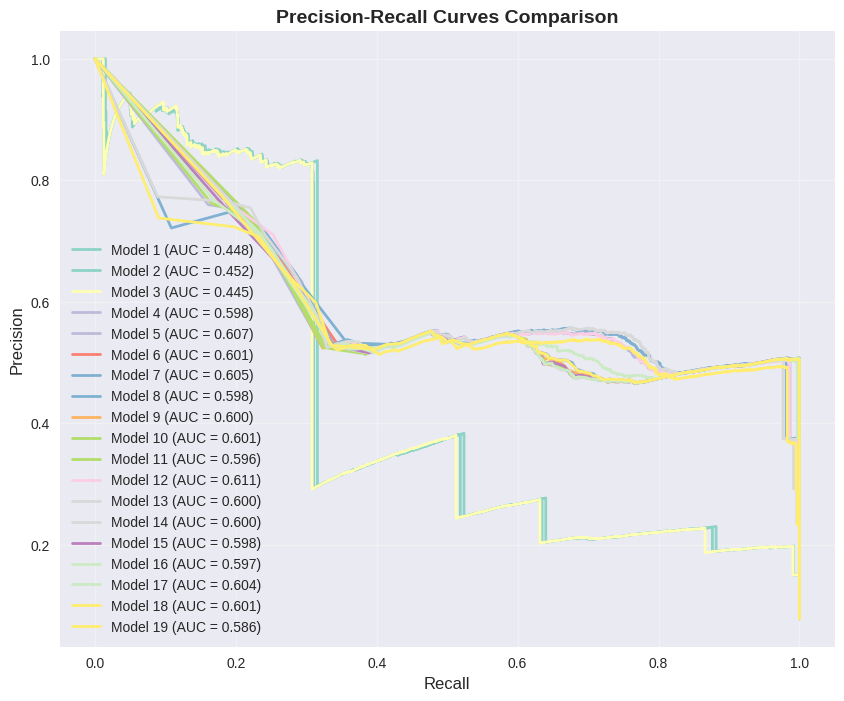


FINAL PERFORMANCE SUMMARY
   Model Accuracy Precision Recall F1_Score
 Model_1   88.87%    30.71% 33.53%   32.06%
 Model_2   88.85%    30.41% 33.01%   31.66%
 Model_3   88.87%    30.68% 33.46%   32.01%
 Model_4    92.3%    50.43% 96.41%   66.22%
 Model_5   92.29%    50.39% 96.18%   66.13%
 Model_6   92.34%    50.54% 98.73%   66.85%
 Model_7   92.35%    50.58% 97.68%   66.65%
 Model_8   92.27%    50.31% 95.88%    66.0%
 Model_9   92.35%     50.6% 97.75%   66.68%
Model_10   92.35%    50.58% 97.46%    66.6%
Model_11   92.35%    50.59%  99.1%   66.99%
Model_12   92.21%    50.12% 96.11%   65.88%
Model_13   92.18%    50.04% 95.13%   65.58%
Model_14   92.37%    50.66%  97.9%   66.77%
Model_15   92.31%    50.47% 96.86%   66.36%
Model_16   92.33%    50.52% 98.43%   66.77%
Model_17    92.3%    50.43% 96.71%   66.29%
Model_18    92.3%    50.42% 98.43%   66.68%
Model_19   91.93%    49.19% 95.73%   64.99%

Best performing model: Model_11 with F1-Score: 0.670


In [97]:
# Initialize lists to store results
from sklearn.metrics import (confusion_matrix, classification_report,
                           roc_curve, precision_recall_curve, auc,
                           accuracy_score, precision_score, recall_score, f1_score,
                           ConfusionMatrixDisplay) # Added import for ConfusionMatrixDisplay

cm_list = []
model_results = []
model_names = []  # Assuming you have model names

# Ensure model_list and df_test_list have the same length
assert len(model_list) == len(df_test_list), "Number of models must match number of test datasets"

# Test each model with its corresponding test dataset
for i, (model, df_scores_test) in enumerate(zip(model_list, df_test_list)):
    # Prepare data
    X_scaled = scaled.fit_transform(df_scores_test.drop(columns=['label','Dst IP','time_windows']))
    Y = df_scores_test['label']

    # Make predictions
    y_pred_prob = model.predict(X_scaled)
    y_pred = (y_pred_prob > 0.5).astype(int)

    # Calculate metrics
    accuracy = accuracy_score(Y, y_pred)
    precision = precision_score(Y, y_pred)
    recall = recall_score(Y, y_pred)
    f1 = f1_score(Y, y_pred)

    # Store results
    model_results.append({
        'Model': f'Model_{i+1}',  # Replace with actual model names if available
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1_Score': f1
    })

    # Confusion Matrix
    cm = confusion_matrix(Y, y_pred)
    cm_list.append(cm)

    # Display confusion matrix
    plt.figure(figsize=(6, 5))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
    disp.plot(cmap='Blues', values_format='d')
    plt.title(f'Confusion Matrix - Model {i+1}')
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(Y, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Model {i+1}')
    plt.legend(loc="lower right")
    plt.grid(True, alpha=0.3)
    plt.show()

    # Precision-Recall Curve
    precision_curve, recall_curve, _ = precision_recall_curve(Y, y_pred_prob)
    pr_auc = auc(recall_curve, precision_curve)

    plt.figure(figsize=(8, 6))
    plt.plot(recall_curve, precision_curve, color='blue', lw=2,
             label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve - Model {i+1}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Create comparison DataFrame
results_df = pd.DataFrame(model_results)
print("Model Comparison Results:")
print(results_df.round(4))

# ====== COMPARISON PLOTS ======

# Set up the plotting style
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

# Colors for different models
colors = plt.cm.Set3(np.linspace(0, 1, len(model_list)))

# 1. Bar plot for all metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1_Score']
x = np.arange(len(results_df))
width = 0.2

ax1 = axes[0, 0]
for i, metric in enumerate(metrics):
    values = results_df[metric].values * 100  # Convert to percentage
    bars = ax1.bar(x + i*width, values, width, label=metric, alpha=0.8)

    # Add percentage labels on bars
    for j, bar in enumerate(bars):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{height:.1f}%', ha='center', va='bottom', fontsize=8)

ax1.set_xlabel('Models')
ax1.set_ylabel('Score (%)')
ax1.set_title('Performance Metrics Comparison')
ax1.set_xticks(x + width * 1.5)
ax1.set_xticklabels(results_df['Model'])
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 105)

# 2. Radar chart for comprehensive comparison
from math import pi

categories = ['Accuracy', 'Precision', 'Recall', 'F1_Score']
N = len(categories)

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

ax2 = axes[0, 1]
ax2 = plt.subplot(2, 2, 2, projection='polar')

for i, model_name in enumerate(results_df['Model']):
    values = results_df.iloc[i][categories].values.tolist()
    values += values[:1]

    ax2.plot(angles, values, 'o-', linewidth=2, label=model_name, color=colors[i])
    ax2.fill(angles, values, alpha=0.25, color=colors[i])

ax2.set_xticks(angles[:-1])
ax2.set_xticklabels(categories)
ax2.set_ylim(0, 1)
ax2.set_title('Performance Radar Chart')
ax2.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))

# 3. Heatmap of performance metrics
ax3 = axes[1, 0]
heatmap_data = results_df.set_index('Model')[metrics]
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='YlOrRd',
            ax=ax3, cbar_kws={'label': 'Score'})
ax3.set_title('Performance Heatmap')
ax3.set_ylabel('Models')

# 4. Model ranking based on F1-score
ax4 = axes[1, 1]
sorted_results = results_df.sort_values('F1_Score', ascending=True)
bars = ax4.barh(sorted_results['Model'], sorted_results['F1_Score'] * 100,
                color=colors[:len(sorted_results)])

# Add percentage labels
for i, (idx, row) in enumerate(sorted_results.iterrows()):
    ax4.text(row['F1_Score'] * 100 + 0.5, i, f'{row["F1_Score"]*100:.1f}%',
             va='center', fontweight='bold')

ax4.set_xlabel('F1-Score (%)')
ax4.set_title('Model Ranking by F1-Score')
ax4.grid(True, alpha=0.3, axis='x')
ax4.set_xlim(0, 105)

plt.tight_layout()
plt.show()

# ====== COMBINED ROC CURVES ======
plt.figure(figsize=(10, 8))
for i, (model, df_scores_test) in enumerate(zip(model_list, df_test_list)):
    X_scaled = scaled.fit_transform(df_scores_test.drop(columns=['label','Dst IP','time_windows']))
    Y = df_scores_test['label']
    y_pred_prob = model.predict(X_scaled)

    fpr, tpr, _ = roc_curve(Y, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, color=colors[i],
             label=f'Model {i+1} (AUC = {roc_auc:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curves Comparison', fontsize=14, fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()

# ====== COMBINED PRECISION-RECALL CURVES ======
plt.figure(figsize=(10, 8))
for i, (model, df_scores_test) in enumerate(zip(model_list, df_test_list)):
    X_scaled = scaled.fit_transform(df_scores_test.drop(columns=['label','Dst IP','time_windows']))
    Y = df_scores_test['label']
    y_pred_prob = model.predict(X_scaled)

    precision_curve, recall_curve, _ = precision_recall_curve(Y, y_pred_prob)
    pr_auc = auc(recall_curve, precision_curve)

    plt.plot(recall_curve, precision_curve, lw=2, color=colors[i],
             label=f'Model {i+1} (AUC = {pr_auc:.3f})')

plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curves Comparison', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# ====== SUMMARY TABLE ======
print("\n" + "="*60)
print("FINAL PERFORMANCE SUMMARY")
print("="*60)
summary_table = results_df.copy()
for col in ['Accuracy', 'Precision', 'Recall', 'F1_Score']:
    summary_table[col] = (summary_table[col] * 100).round(2).astype(str) + '%'

print(summary_table.to_string(index=False))

# Find best model
best_model_idx = results_df['F1_Score'].idxmax()
best_model = results_df.iloc[best_model_idx]
print(f"\nBest performing model: {best_model['Model']} with F1-Score: {best_model['F1_Score']:.3f}")